<a href="https://colab.research.google.com/github/AnnaScibska/Deep_learning_flowers_data_set/blob/master/dl_ost/05/CopieAnnaYouCanWorkOnIt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Exercise instruction

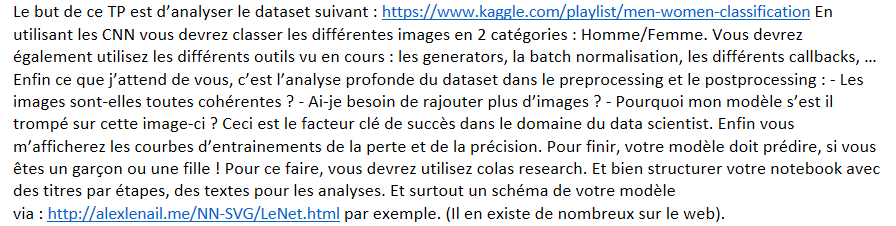

INFO: We decided to use GPU (over TPU) because it was much faster when training model (11s vs 132s per epoch!)

## Import Library

In [0]:
from contextlib import contextmanager
import os
import sys

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import math
import pathlib
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
from PIL import Image
import io
import base64

import pandas as pd 

Dataset : https://www.kaggle.com/playlist/men-women-classification

In [0]:
@contextmanager
def suppress_stdout():
  with open(os.devnull, "w") as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:  
        yield
    finally:
      sys.stdout = old_stdout

In [0]:
file = open('/content/kaggle.json', 'w')
file.write('{"username":"pietrinicolas","key":"dd6c8cd0e5a0036dea1dabaaf8f1daee"}')
file.close()

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d playlist/men-women-classification

kaggle.json
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 190, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.


In [8]:
print("Unzipping files...")
with suppress_stdout():
  !unzip men-women-classification.zip
print("Files unzipped")

Unzipping files...
Files unzipped


Move 12 files (6 men & 6 women) to prediction folder

In [9]:
! mkdir prediction
! mkdir prediction/men
! mkdir prediction/women
!ls -Q /content/men | head -6 | xargs -i mv /content/men/{} /content/prediction/men
!ls -Q /content/women | head -6 | xargs -i mv /content/women/{} /content/prediction/women

mkdir: cannot create directory ‘prediction’: File exists
mkdir: cannot create directory ‘prediction/men’: File exists
mkdir: cannot create directory ‘prediction/women’: File exists


move the rest of the files to the common folder

In [10]:
! mkdir people
! mv /content/men /content/people/
! mv /content/women /content/people/

mkdir: cannot create directory ‘people’: File exists
mv: cannot move '/content/men' to '/content/people/men': Directory not empty
mv: cannot move '/content/women' to '/content/people/women': Directory not empty


##Adding our pictrues to the prediction dataset

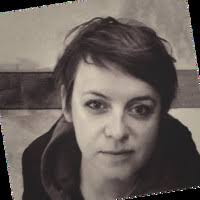

In [0]:
anna = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEBAQEBAVEBAVDQ0NDRUVDRAQFQ4NIB0WIiAdHx8kKDQgJCYxHB8fJTItMSstMDAuIyAzPz8uNzQtLywBCgoKDg0OGhAQGisdHR0tLS0tLSstListLSsrLS4rLS0rLSstKystLS0tLTcuLSstMS0wKzA3NS83LTc3LTcvLf/AABEIAMgAyAMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAgMEBQYHAQj/xAA/EAABBAECBAQDAwoFBAMAAAABAAIDEQQhMQUSQVEGImFxE4GRBzJCFCMzYnKhscHR8FKCkuHxJENTkzRjov/EABgBAAMBAQAAAAAAAAAAAAAAAAABAgME/8QAIBEBAQEBAAICAgMAAAAAAAAAAAERAiExEkFRwQNxkf/aAAwDAQACEQMRAD8Aw1BaXjfZkwH85luLezccNJ26lxHdSWP9n+CwOsPlJeyjJI7ysB1A5eXcaa36JfKfkTyyJLY8D5HBjGl7zfK1rS4n2AW3Y3hvBjbyjDiPna+3M+I6h0816KTgjaxoYxjWNAAAaxrBQutB7pXufSvjWGx8AzC0u/JpQ0NDy50TmNDbAuzQ6/SzsCprH+z3NfF8UmJh8x5DI4vLaBvygt1B73pstbe8mySSSSSSSSTruuNS+YvLOcT7M3U0zZIB0L2sjLrFjQOJGtfq/VS7Ps4wQ4H4k7wOU0XxtDtdQabdV2I+SuNLrQp+VVk1EcN8N4MALRiQyAuLj8SISm9a1dbhpWgNaJ5w/hsUAAijayr+6xrbJFEmvl9AnlLvIVIkk9CNZQ0/whv+XXT95XCxHr5oxanumbuYjxhKgDqjNA6JAXlTLI7J++gDqovIenAbvOqUcflskgb0pOA0BuuqYIvN6BHjOlIRNs6bo8or++qADHLsgO6Ta5Kc2mqAKQK29/dU37TsC8eDJugJ3QEfnDzuc0Gx+EUGCx+sFcQFWvtExufBLhp8OWOQ/eIINtrsNXfuTmaVZUgggtGb0VS4V0FALBq4GowCFIAoAAd11q7SAagOhqMGoAIcyA7SMCDum82Q1gJcaHzUPLnTS25n5mEfedpzP9AU8CXzc+GEXJIGHtua9lXc/wARl2kZMMWvnLQXv9h0URnZjA4uDWk9yC4A99dyoOecGzdnoqnITGdxuRlGOaR2v43h4d8q0UbLxfJmeCZuQjVp5vhgJiyKR2wP9EX4Tgdd/UKsSsvDPF0n6OZwJuhJV6KYZncw5viAje9NlSGxdaH0SjGjpbT6HS0sNcW55vax89lIQ5sbgAdD0Bvf3VLhnlaNXEj32CLLxGVmoIrvV6Iw2gRVa7mdAqbw3xO5tB4DhfSwQrZj5zJ2BzTY/n2KmzATFJRp0Pddl22RNkBzn6Jnx/Ga7Dy7bzVizvFi6cGkg/Ii/knJdqPdLlgka9hDXNc18ZDmlwoitrHf/nZAYGgnGXAY5Hxkglj3RuokgkGtEFrfDKXZr0EhaAC7SwagdF0IUjNCA6B1Rh3QAR2s2QHBX8UkI7P8E5IScgNGtNCgIt2OZnku/RNcQB/jI/koPxNxcaxMoADlNdAnfG+NCJhiZpJy0T2CouS8usk9VcgpHJlc80DoNANkGYT96+lFJCT0/ilY5CNQb9CFaQkY4ehRoJzs7X+qWbkg/eC6A06g18kGcCNhFtIB7EojseqJHkJAPoUtCwHSw75JfHmLba4Ww6bbBIzSFpY7lOo/AejghkNrcWCnvI0CnHy/h7hM5pPw7190+iAi5mjcf2VKeG+Lfk7zzguY6rrcHVRmQHWdEg19evdNLV8bNhnb+aeHHQkbOA9QiyM7qqeHMiOUhr9JGaxvBIdXqVb225uurgdfUd1nZiicTRr1RYiNQRY7EA2PY6J1C0C0lOwA2EBjPiiEszMkXvPJIP2XHmH7iFxTP2mQhuaH2HGTHileQS7zeZuvrTQuLa59Mp6a7a6ky8IweO652pUBGa1M3SkbG0ePIPVGA8a1HaEkyYFOGIA4YFG8RzWxtfZoBpJUpWh+ay7xZxNzpHxg+Xm19fRPmaEVxDKL3udZ1cSTd6dk01d/fRJA2fbdPcOIvcB3IHzWpEI8ezXXRdycdzDqrQ7hBidFIWlzf+5Q2HdDxFhsfUkbgehAIuktGKkCeyAeOoP1T+CHXldp6ruRwxw1CYwljTt6WD+0nzMoV96j6g7qLfE5v3m0uE9jqgJKTLPUBw9drTeXL6U0D2Ue55HcIhegaXyHudu5MyEoXohKaadcOyzE9rx0OvqFpnBMlsri5jg5pjaPnqsnU54Wy52SgQ246Es1p4U9Q5WhyNPMeyPIwcv97p0Ig7zEUSASOxSb49a6LNTNvtSxqOLLVlzZYibcaaOUtB6bl39hcU19qkJOFEQLDMppPl1aHNeLJ7WB8/dBa8+mdmJhuW3qf4Ixym9/3rPnNHbTpqUfkFaD6kqcWv2PktA13vRLflbe6zloB09upSwY3tf+ZHxNocWawak9ehCeDi7RtXzcFlxY3tW3U7oxMYGwP1KXxGtG4z4iDMd5aRzVygAjdZlO8m3ONmyfcoOkjNcoqvfUo0rbB7DRVJhEIWaX3Ks3hHD55Rpt/BVyHYD1AWkeAcQUXVsAP8yOr4EWUYjSACNhSRyODxuaQWjqNhspICkewsdUoPEPDYB0sBIRYTmeV45m9D1V7niB3TKXGHZXOgpHEOG3sLHtqqzn4ZaTWi06bC102/mo/N4GH61R9t05RYzBxKLatPFfDThZaK9FXMjEkj+80j5K4izDcriMuJpcTvhGYYZo5B0cL9k0XECNfj49BQ1PT8BXTxyA9T/oKquA3miY692ApX4Z7rL4xoe+KDDl4eU0EtLMaSYE037pa6hZ1stA0s/RcTVmKJeeIu5WvjdG820Uw70TpdXXquq+cz2rn+Lrvzv+1UZJEUSUB80p8EDeyfW0R/KNgmgbF8xPXS9k5Lv70TTGdRJ9CEHvIQCkzwkHO/uzsi81o2+iCEhHmHupnDwjIPhtoaF7ieyYQ4vU7KwcJjoSEf8AiN+2iVORXx5C89RbR+0tS8BwFmJGTu4Fx9bWY8SiqQN7kGvVbJwTH+HjRNHSNv8ABT36OHpFlHa1NH5DgSGt5j/NRPEeJ5MWvwi5u+hGgUYadeE2kCr+N4sieQ15MZ21BGqkhlA6g2OlHojAX5F0tSDZ0p8cJhyXHBGoUPxHhcbweZoKlZM0AbpjPlA9QiBn/GuCBhJj+YVfcCNCtC4jLG6xYJ17Km8Rx9SQtJU2I1GjbZHuuFHgFuA9QqRFw4MR8FgOlWNk5efRNcFpDR+yOpTguUNB8d3mFg1YuiGmvQkED6H2QSfOdCB2IXUBUJHnUpEutPxgTHeMGr/GN04Zwef/AMQ/9jVWpR0G+xTiWG/ZSEfBci9Ym9PxhGy+FZAryD/WNktNC/DpLwRg1ZpP4uFZDtBGD3/OBLDgWTX6No73KEaCMFEqe4PEHva3oWkFNMfgeTWkbP8A2f7KR4XgZEUzHPY0MF2Q++h9Eqav5sXNnOFaB4b8tFsGDXwwOzQsoy4XflRfVEyB/wC9apw46AegU9BHcU4qzHaXPNDX3JVQzPGzjzFsXM0EC9f39Fa/EfA2T/eBI10VUyeEysjMUbgY7tuga5h169Uc4DCTjTJjT427CxVGlJcJrT4b9L0BJ0UPgcN+Fzc4DiWlrbvy+qmODcNN2HgkEOFXRVURZGQurX+ymXEMgRNcXGqBVqx4bYL3rVUTxrG5zhG3ai53sonmmgM/jkshph5G9+pTNmPNIdZt+5KccNxHU9zQOZrSbd/IKIlyJJH8peT5q/w/uWiUo/g72Au+LZG2hUcXl1hw1FpIZcrSWFxI236p3DH5S87lAQr9yn3CsXnNnYV9UzcLca7lX7w94TmMLXEtaSA4A3dFO3EyG0I0A7abI5f6ein2eGHiiZQD6MP9Vx3ht3/mH+j/AHUbFoDmK6po+HHDT4v/AOP90EbAYO4d5nUDXMeWwBp8rSrY67qQxpvisjlbfJJG2ZgcWlwjcLANaXRCO+MbkIvsGLcgj8P712XILtC0D67IZMCK1lVeyRuQx9tE8jZQ1v8A3XYmDROw0fNAcieW1poo7j3FDpFF+k0c86eRvqi+IuNNxWCvNM6xE3+ahI4uWPzEmV55pTepcU5Bqey4mSRtlaPMQCfQq08Of5Wn9ULLjmyQgsY88p3BorQfCuX8XGjddnl5XftBLqeAsE1Ob6qFy+Hh3p7KUjKP8MKPQVpvAGE2QT7qUxeGtZoAAPZP30NzSTjyQ7bb+Se0FGOoEehVNz/zszrGg8quIGh9iqnmgRvLu5P1TgRWXhSsstPMNegsBV7Mw7PMAWnW6aAtAxpGvFgghJZGIw2aH0GyrRjPcPhRc7UX/ROuKxtjZytFaK2OjYwE0AdVUvEE1g0nukrTXUbBog2PdaF4Y8dChFlEDQBsnT5rOlwqrNRrfIchkjQ9jg9p2IIIKBWQ+F/E0mG6jb4CfOy9vUeq1HhnFIclnPC8OGgd0LT2IWV5xUunRQQKCkKh4Qz2TYePynzNgjje0yFxYW2266A8pICl3FVH7Mn/APRSaj/5bxXmuuWP0rr3vVWsyLSyS+BLs0YDujOhB20RDJog6cNBc4gACydgApMdkRGlKO4v4jhxgW/pJf8ACCND6noq3x7xW+S44CY49Q5wNOk/oFWHH6/zVTn8lam8KZ+VkmaXUjzAdG9gE+4hmtjvW3aqOgmGND/9r6PqxvRQ8sxcbJsqsLcOsjMLv76LQvszyuaCRh/DLp7EBZiFcvs1zOSeSMn77AW/tBHU8CVqMZSrpaBTYPSMr72KxWb5r3yWG+qUxMhjY2gkAjy6kbpxFGAPVRWZw9jnEkdb+aYTL8loF3uFT+OZzGvon/hGz8x7LY3XQ1aqn5JJPKS8kG/XZVIE7iTlhsXynUeyl3ZgLbSIxh8NrezQE0ncGikA34jk3/fRVDjMt2pnPyRrqqzmyWVcTTRcXVxUzBTnhLjb8ScULjkLWSjXa9x6qCXWuIII3BBHuim3m0FF+HeKNysdkg+9QbIO0gq11c+LZz9l2SP+qiJJcRFLG23U1o5g53bqwf8ACvYCzL7OMhrMwtIBL8eWJgIJ81tPT0aVo0DjZ7LXqYnk+awVZ0/os/8AEnHvjuMcekTXHW9ZD39lZfEWSWY0pBIJaGD56LOUcxVo9p1gsFl7vusAdXd3QJpadynlia0dbe736KiIZMxe4uJsklEaiJZgTIW064bmOgmjlG7Xh3uOqbFcSDccbKEkbXtNtc0OB9F3npVzwbNWJED2Ne1lS07y7QH/AIWWLLP4rGHBpe0E7DmFosvEIq/SN+qbHhsLmkOYCTuSBaj8rgcVGhXsSEeDEzJWF/PzCq7qMdxSFrjrpr8yksjgbST53125gozK4ZG3r9TZVkmR4gjLg1ru31QnnLr7UoXDxGg3XVSWTKGsNbowIfiEupULM6ynebPvqmCpNcK4gVxNIIIIIC6fZpnBsksJdXO0PYO7hv8AuQVQxMh0T2yMNOa4OafVBR1ztVKZ+FpizMxi0Al0zYdQD5X+U/OnGvWlsIYAdCCDsQQRXoRosPxMgxyMkaAXMkZI2xYLgQdVurCHNBa4ODgHAhweCD69U+/SeZ5t/r9oXxY0nEk9Cw/K1nS0nxTCfyWXS/KPpYWbI5VRqTrK0DR+q1NbS+QTp+yPomRBOWDRNxunUeyYhJyTtLyikgNx7hIVpvh0VjxD9QKYGnsofgDvzLfYfRS0TlnWhxvsmmUTVe6UL6RXzhIIOeN5PWlHyYNkk+qsE0oUfkSga2q0kJkDk0Ubm5em6V4vlanqoGV5J1VSFaEj7KKgF0qkioFdCBQBUAggggQQKCAgVuXh6Rr8LEIcHViQMNG6cG0R8qr3tYatd+znO+JgMj5SPgySx3qQ4kl9+h89V+rfVT0fKZ42Lx5W9PhO+tLJ1r+fHzRPF0OR1/RZAf6pcH06E5Lba0+iapzim7afce6soSI6pYSGtEu+Actdd02ZG4E6aDf2SN0AndJuGqM96I06j5fRBNI8OA/Bb7BSrX0o/gBBiaRsQE7m01WdW7PNoVDZGW4XSc5M1plME4DDIz5Lu01yOIF3olMoDVR0qoGmQ/cpo5n1T6RgGp26epTV3dNNJhqDkcAnZD4RQQg0XCEt8E0TRoAuJrQDuUZmHI5rntaXNa3neWgv5GUTzGthQ32QZpSCcx47XBzhNFTYzK+8iFpDR0AJBcfRtlM3ZsAdVue2hq1oBuh0PqhI5QSp4thsdzNhklaXTgxveIzHGQOQiRpPM4Wd2AWBoQS0BMlcWmfZXxX8zLh1/wB/8pFFxLrbRsXVAM3r8S6gl16OXKsniicsxZiNyzl9gaCyxBBTz6VQQaa1QQVpSWPLzC+vVGnBr+Psggkr6MpI9L90gCggmVXrwVnhzDGd27fsqySCwuoLO+1RFyw2iOhsaIIINFZ8Dqvl05mss6DmIcQL7kNcfkeyYOxOTkdK5sbHAFjnPAaR5uuwNtOh1QQVFaYyOxy9hlymNiLog50f54xtIBPk0cSNQeljfYmLPEMcFzSXmnkBzWBzXM7gEtOvrW/yQQVYnfLj+OR8jgyEh/N+bf8AFHLy237zaJOgOzhv1RZ/EkrmkCOJjvLyuZG5rmtBca35TZO5BNAC6CCCC/ZnlcZyJHukdM7ncXOkcKYXvLi4k1VnmO59OwTTJnfI4vke57zXM5zi5zumpKCCC0iggggAggggP//Z"
nicolas = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEBAQEBAVEBAVECAbEBUVDRsQFQ4WIB0iIiAdHx8kKDQsJCYxJx8fLTItMT1AMDAwIytKTT8uQDQ5QzcBCgoKDg0OGhAQGi0lHyUtLS0rLS0tKy0tLS0tKy0tLS0tLSstLSstKy0sLS0tLS0tLSs4LTgtLS03LS04LSstLf/AABEIAMgAyAMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABCEAABAwIFAQUEBwYDCQEAAAABAAIRAyEEBRIxQVEGEyJhcTJCgaEHUpGxwdHwFCMzcpPhU2KSFSQ0Q2NzssLxF//EABkBAAMBAQEAAAAAAAAAAAAAAAABAgMEBf/EACARAQEAAgMBAQEAAwAAAAAAAAABAhEDITFBEhMEMlH/2gAMAwEAAhEDEQA/ANMUSUiWjApqWiaEoFBkI5RFHCANidCaYnEGUFgaZjOH+dUrehYTHt0ZwCOXA/IKsU5eNrh2wwD1+8pZKZxGLp02l9So2m0TJc6BusZmH0kYdpLaVN1WLaidDZ+9Sem1JRSsRg/pDpu/iUiJ+qdR9IVu3tXhCWfvIa4TLhp0nofmgl68plzk1TxtJ4ljw4dQUTqjfrBCOxvKi1CnyfMfamXUp95v+pJNQcQbKkzBy0FbCOOzm/61XYrJKz9nM/qJwtM1iHWVdUK09XsviHW1Uv6v9lFd2PxR96l/W/sr3GkZqoVFxGx9FrHdicWfepf1v7Jup2Dxhtqo/wBX+yr9RUYcILYD6OcZ/iUP6x/JBP8AcN1gBBKSVgDjUAgw2QKYE9Eg5AIA2p0JkG6eCBBrnvbHGtw+YCuRIZTa6JjUY2XQQVxT6RszNbHVmRpbTdo/mIG6cp62g9pM/qY2qahkM91kyGD81ThxFwiHkkuYSqXDgdsTvx5qfhKzQIeNQ1Wv5KsEzz0T8OEmIBG6QaHK80NF4NNztJvpPsm15W6yjN6eIBiWvHtMO49Oq5bgWEm4JkWAN1c4bFmg9lVm4v6iIMpWIyx26SUabwuIZWptq0zLXCR5eSchQxsBKIlElBBFNCWEkJQSMoJTUkJxoQotjUE/hWSQESS5jsuERSiklWCmlHKbJSmlABxQag5EEbGhjdOhyYJRymCcdi+6p1KsToYXR6CV59zLFurValVxlz3lxPqu+4oBzKjTzTIP2Lz3F4QrFLw9C0nnZTMNhATdBrbAKdgW3StbYztOy/s62taYPCu//wA+qupFlJgc6ZBNUNB8iD96XkDSHA8LouBJ0ggLlz5spk65w42OaYf6Psya4eGnTH1u9Do+xQs87PnCVmsqyab2yHRYPj8wuysc7lZn6QaTXYUhwnxW8rFVOa2oz4ZMbYzXYqof2UsO7KhB+N1eELO9hvZr+rPh4YWjcFvXm5zsSMIQjakgoJQCIJYQCgE6xNtT1MIVFhgafKCfwTfCEFF9dOM6QHJKccE2StGRDilNKS5E1Mi3bJIKMmxTQKQKebo9SaeSlAo2AcJkdRC4a7LKjKj9TCGsqlrzpsHDhde7TVXNweKcww4USQQYIXJcBWqanDW6HNJeC6Q423VReM62RXxAHs3UjBZm1pEtI+ChhpAMbgwCRwjIqCenG109baS6dIyDGU6gBButjhc3ZSAL3AN8yuJZPhauJxDaTKjqbi3cO0gRa6ssdgsRSfWpYio+oKTw0tL/AGnbgz0iD8VyZcM/Xrqx57MfHZXdp8HE980k7Q6SVU9tgK+ArOpnVpbrbHlc/KVgMhxmppb+yU3RtvrmQLXB54V5mOIxNMClQY91GtRcHU3kONBwA1nUbxpmPNH89Uf0/WNQ+weois4mxgR0O/4rUOKq+zFKhTY9lGQdQc5rnanNBFpP63Vq5b7287kxsvZISwkAJYCGYwlhJaloBbU/TCZan6YSXIucGPCESXhR4QgorpnirqblNFO1dymnLZjTbkTSg5JYUknCU0CllMykBvKAcm6hRtNkgTiaYex7HCQ5hBHWQuM4OnoeQ7c2C7NysP26ydlIjFUyQXP/AHjYsD1Hqqxq8MvjMMpkmB1+xP4vBtazV39Nxj2Bq1fdHzTLDMK8JpsoucWtkNsSJvwjLLTfDGVH7CUz+1tdEcegldL7W5PSdVL6jhTZVpgB+mdFZkwXR7paSD0gLm/ZTN6eHq3Eg873XTaea0Max1GZe1uoiDt6rn5LZlt08eOOWH5ZvDZVVwtRusNHLXB4cxw6gq7rEvZWrukD9mc2mIgP1CS+POAB6Hqn8DlVFju8Al0bkAlFndWQymN6jwPhMn5BT+93pX4/GPaqybCae9r6dJrBpA6Q0fipzinqxBNhA4TBW+PjzOfP9Z2gAlhJASmhNjooJYSWpQQrRxoUikEwwKRT3CFxdYYeEI0dAeEILN0RT1xcplxT+J3Udy2YU25JBSymwkkslMTdOuUdxukKN6NpSXBG02QQEqk7aU9WEd62+auXmLnYblc77R58/FV3Uabow9KXOI/5sWv5TsnDxZvD1TspGMxbntDNgL+qh1DDvinoa9W32Vg8M51gQDN56Sum9m8T3Wk7gtg3lZPIsPgbCqHAn3g8iPgt4zs5gajQ6kajAR7tcrn5cp5XTxYa7lWQrsALgfD9ypsLWNeu+r7jPCz15Kh5hVFGmaQcSNVr3Ks8uw/dUmt5Il3qVHHh9R/kcnWkhxTaNxRBbuAbU4EgJQQC0oJIKWEGWxSaO4Udik0BcKdqi7ZsEEdMWCJS6FPiNyo7k7VddMuWrCkFNpwptx/ukkZTFTeVDx+e4akDL9bos1nik9J2Cw2edoKmIdF6dIDwtB39TyqmNorYY/tLhKNnVQ49GDWqR/btvuUIHul74n4BYWu66aLzf1V/iHppc17V1sQAwwxvIaCNfqs/lLx+0Oa4wKjS2fMi3zTWpRajiHBwtBt6qtQ5E6vTMkEQ4GCOhUjKwCS12ylZhR7wU8Q0WqNGsdCmmYQkgqVztocBlFN7mnXpEz6hbl2Lp06UMsQFzOgK7Ygg9PEtBl2Dq1oFR5YznSblc3Jhv2t+PPXUiRgMMcVXBLgGjUWF21V7Rq0+Y/NXOLzHuqjS/wD4eoJpVPqk30lU1PFNbmNKnSbDaDAA0GAXEyflC0uPwob31CswEazAIs6mTqbb029FrhNxzc/VIbWa67TqHklLE5dnHdVLAlhdIB48lp6WOcRqADmlstjf0PmqywsYbWISgo2GxIeB7p6FSGPBmCDBgwdis7FS7OhKCQEsIUcYpWH9oeqitUrCjxD1SqovKeyCDEFLoULim3Jbk25aOYziKrWNc9xhrWy49AFzXMc/q4lzgXFrZ8DAYb6ea33aAf7riP8Asn7lyKg4g36rXCFU4g77A8dE0aduilCekghIDZ2BM72haJ2g1sJaReOOVVOmbXPIWp7olsNF4380VXLhVo62MDHNEmNzG49ZS2cyZopquLKW5iZqixCelytD2QqtfTdRebB0H/KDyPRXX+zSxxY4CR02cOCPJYns/iu7rC9nCD68Lp1J7n0aEiZbFN0bmfZ+2VlnjbOlY5ay1fEOngwFIOKFJpJ4CcxbtDZHIWdxj31SGN3cYAXPJcvXV1j2V2UmpXxNZ1/Fv5wui52wtfTdUOrXh2Te5eBpKzeV5SKIZSYCSbO8zyVcYyuxz30w4uFMQ4EyJN49eq6cMXFy5bYzNsAxriSXM8VgLiNxCVhKrqDxT7wVKegEcAzcAhT80YHB03dvPn+pVHiz+9aR/hN/H8Fqx9a2liAbgQZ2ixH6lTKRArNANqtMwONTfxIPyWawmL5dMRzxdaGu8NpUHTDhXbpvsDY36QVnnBj6sglAoPiTG3CAXM2OsKl4P2gobVNwXtBBxd00EGIJN2fcm3JbkghasGV+kDHup4dtNo/iuOo9A2PzC5qxxdJ5G60fb/OTUxAa3+HSJb/OeT+uizAInUDY+a2wnRLqk8lodtBv5qS2nBnYTadtlEw9SaT7iQNovEqxo+IR5WkRwqZ0imBqDZgG8xzKtsBTAeWkgtqeJpA2d7327/aql5LX6juDyIhXmEoa6Y0kCo06mku2N/Pm4+KjIIWc5AwteWsioL2sHDp6rGYikRNvt4XWcIf2imHARIjSRLmHpf7lUZplFN3jcwagJcIDeN/7oxy/6qXTltIQ8dNV/JdgycipgaTTBLZkdbrmed4IUa1vYeLWjSen66rpfYvAGrg3wZcx1/Q8q/h5dpme4E0wWubAN2EbPadiCq3srl4fUqVjcM8LOurm3p96njE1H0nYepLmNdDQT/CJ2I8loOxWUPw+HZ3oAqOGpwjqfyhYY8Wq3/t+sWexeLGHbUrPBDaYLjbngfEwFnewuLdVbUdUd4nOc51h4iXLo/bfANrYGvTgXZIMci4XIewNQh1QSfhuNpW8nTmymo0OZuMiRLyIPF7hVWcM8NJ4+rpPAkGfxVnj3gyfanzjdV+aT3LGjmd/gmzhGVO1EA3PA6W3+a0WaYgkhrTZrqbXAXlxdKznZ1hc9osDO55V53xNU7NmuXO8gDb7Tf4JWCtOJgTv5lKCZfXaHU2yZe0ls8RunVyZdVtDjVOwHtBQGqflvtBQ0nq8agg1BJqzjlU9p81/ZMM+sBLtqY/zH8t1bOVF21pzgapJ0lsOafMHb5ronrByauDUc5wMkmSD1UfQWyR8QpLIJn2XeQ8JUuhSJMECeDqsV0aLaPgcVEzfwu+YKv8AJnioG7/C9vzWZxTAwlzCR9ZpsT6Ky7NV+JIHMBSnKdbXuMw9pG0STp0/fwnsixRFTSbEi4iAApncB1MEWBFvEbAndU4Ol8xIBuQ60JIjV4d0VYYCKdXjVtU97Y8i/wACrLEUJBLjzaDuellmMPXL6D5/itdrp32I+XBHxWrw2IbUpCo0DS5kjoosU5r22wvhJAMsdM+R3/Bbb6IMXqlp9+l16Ko7U0dbKzQ0XYT8YTH0T5gyloNQ6fGQ08cbq54Jemq7Q0Gsr1BEE3MGJHK6PjaYLQ5u2m3pwsf23wo1MqD3mxK2rWTSaP8Apj7gnfisZ3Yz2Y+Km4HpdcQykCjj6rBsXHSdwDcfiu1Zo7TTfPouPZzhzhq1EuEOqkvNrtbNlSKscS0+IXtcgfBM4ynrwzifaa68AC3mhi3k3Nuli3gbpyhUDBpcAQ8G2/RDOI3ZdgNZk7aoieoKdy2u6pVD/dDvCDud4lI7Mt0Vpu69ht6SUrA4SqyoQahNMVC1rQLEAncoF+tVhC1zzUc4EhsNvZgJuB8lZqnwFV5LQBb3YbafVXJaRuublne2nFdwpqscs9pVzVY5Z7XwWDfGdrmmgg1BDVniFzPtjnzsS80qc9w02Av3jh7x/ALpVRsgtmJELi2PwwFVzNWmqxxa68teQdwV1YTthUdmGIIMx81Pwzm+hJvFgUWHwjgLiehDgVMZgWR4mFs+Rhbs7UPNcCIAi5HgIMgKoy1xp1CDuHLS08O4t0vu0jwxu3zhZ7F4N9KuA7n2TwVNPG/HR6I/cNmHEt3HXoFRkw4sNpPiBO6tckqN7poBuep56CbKtzK1S5kNME8yoQTQeGPaOCQTEQPKVpey+KaGVsPzSqw0EX0G7fks2aAseA69rR+insJijh8ewnwsr0NMH6zdrj9XRTi1zATVv7xg2kHhYzs7Rc1gdwXmPthbXNKd2mwE2vvO6q8Tge5ZQZaQL+UuJ/FOUSuhYWr3uWxW8RbSJB5BAMH5BbDCvmkw890P/FYZ8ty18C5okfaFr8K891T1GPA2CPTlOtMVVnsS1vBuua/SrSDcThoG2H/9iuoZxTLqlEHci6539LdE99SfwKelNN9rMVKksBkHpcmLBN4ipPcu/mFj7Rsk4V+unB4FhxKKtOmkAbgH4T/8TZ+NFktPYgAAXJ6LPYvEvFSqWut3pLR1OpXmSVDqbJkgi3Cx1PFTUdIMl529UJxm9t1lGanS3U0AzIKt8sxTalR8S4hviPA8gsllhc5pa0QPrblo5stVklNtNg0AtB63JPP2wozx6ol1kuGlWWVDxKsaRuNjsrTKdz6LirswW4QRAoIasX2mzT9lw7ntP7x3hpfzHn0C5I1gLpPidPHVaf6QsUamKdTLiG0mANHUkST932KlyvDNLt4jYu2K7cJqOXKktY8EGDv9qsqVN+nUJsfEET8JUFwQRHG0KTh2VNibxG0yfkrZ2jZSc7xBxDYkxbSR5rG1nl2Id43PAdYuN1vaDHgnxAA2I0TIusPmAa3F1Qw+EP8Ad9LwpqsPrZZE86BBlsX4Nrk/YVX5tXJfv4t59OVKyfFNYyd7dfOx+5VuaOPeG220cSl9Kep+UvDovsQB03Vf2uqOZUoVGkEMdPBAMqTlbi3mGx+pUXtMC6nsLQUCf7NXUxLatJrgLR4Z920pWIpmo4eZ+SouyGI10AySYvtO3C0VAg1gHTo1dOEJs1WoNSmaAokwNMK2pZqGtDTeGgfJUWbZU7S4094t19VJdgHNBmSAL+app3E//azHOkkSD4TPBus/9I9FlbC94CCWmRf9dVX5q4tBIHCx2YZy+C10lhsRMIT3UXKahhwiRMBSca0TJEeAAwq3K67RUkG0yJ4PmrTMXTUBHLG/JMsvVhldbSJkezPmFha2Kcaj4sNZ29Vr6bwKZi2828li6TRvIklA4/q8yTNKlFzXahY83Wow3ahszDrbFtIuHrssI17BEjWeRwrXC5pVcWsa4UxEGBeI+SdGWP10HKs+w9U6e8AqE3DvA6ekFa7KhuuVYfMIcRFWoRuQxvO/C33ZXOKdSGAuJ2hzdLmrm5eP7GnDnq6rVoKFj8cKYjc8BBc7ptjhOfZs2tiq1abOd4Z+qLD5KLSzBtwATPkggvQkc+trfL8Yx50klpjlqsqMm2qbSb7DdGghllNIWdYer3FUiq6A3UItPksXhnkOCCCVXx+Nhhg3upbZxsb87KHUkkiwmQZ6oIKS+plCoAGg8i4AlMZiNTSCZAs2eUaCZfTHYvEgd5TJseJiZXUcvyovoU6obILbcltyiQQqzeS6Ie7DPAJ16dLT5qzwlUV6TKoBhzb2964Ij1RoIqsWYzjBe0wxIXL89wulzm8cIIIT9UGEeWPI+M9OFoHV9bqJG2iDfkEoIKoM4bx9YNaQLS1ZSm6B1QQRTwnSdRkiSQ0cDkqVgn3DWCb3JsEEEyy8avLHhnhc4FxN4fb5LV5fIgg6pFmmzh6SjQUZMZ6k4+odUm8iyJBBceU7dWM3H//Z"
sebastien = "/9j/4AAQSkZJRgABAQIAHAAcAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCANjAnkDASIAAhEBAxEB/8QAHAAAAQUBAQEAAAAAAAAAAAAAAgABAwQFBgcI/8QASRAAAQMDAgQDBgQEBQIEBAYDAQACEQMEIRIxBUFRYRMicQYHMoGRsRQ3dKEjQlLBFTPR4fAWYiRkcvE2Q2OSFzREU1SCJTWD/8QAGQEBAQEBAQEAAAAAAAAAAAAAAAECAwQF/8QAIxEBAQACAwEAAwADAQEAAAAAAAECEQMSITETQVEEIjJhI//aAAwDAQACEQMRAD8A8ZSjoiTxhaYDCaEUJQihTp4TwgGEuaJLbkgZKEWNkoQDHVJFCUKoGE+JTx3ShTYGE/ZPGEybCHJP8gkEoQJJOmVChJOkoGShOEu0oGSG6dMmwufZOknUDJ4SHdLCIZLnKdKECShOkimhNyTpc0Q0TlKE/NLdA0Jso0hugBJERmUlQMJQiSRQkIUaaEiB2SRQkoQ0JoyiSjKKCE8JJ1QMJJymVDFLKeEyBoSCcpd5QNzTwkkgSWE/okUDc0ydKEDJkWyZA0JJ4TfNAkx3Tn7pIpkkk6AExRJjvuivp/3FflrS/VVfuF6WvNPcXj3a0v1VX7helrCkkkkgSSSSD4dhOlHNPC0waM4SjCdOopoCUJ0lQ0YSRAJoRDQnTwlEIG55SjsihKEAwlBlFCcBAEJoRkJEIBjmlzRYSwgFKEUJQgGE8Y2TwkgHlskiTRhA3ZKE6dQDHdJKOScBVKSdKMpKBJvqnS+aKSSUJIhQlCdIBA0JJ+ySBowmjKLmkUDR9kxTpKhkogp4Tc0DFMihNCBgEiESSig6pQiSQCknx1T7hVAc0yIpIoSmRckyBvkknhJUNCUJ45JIFCUJJKBk3NOSlzwqGSTwmQLmmjKdLdAyaPqiKUfJA3JMnKUIBTIkJlFfT/uM/LWl+qq/cL0pea+4v8tqX6qr9wvSlitQkkkkCSSSQfECXPKQTwqwZJOnVDJ4SSUCTJ4ToG79Uk8J1VJJP803JAtikknj9kDJJ0tkQKSKEoygaBKUJwEoQME0IoS5IGhKESUIAASjCOMpQgjAhEnhOpQMJkcJQgBPCKEo7IBTQjjKUIgfql/zCKOybGyBuaSeE/JFNBTIoShEDCUIkoQDCYhFCaEAwnTxhJAKZFGUoKAeaaOiLmlAVAZSgo00d0UBSRQkgH5JJwE8BAHySRQUyBJJck5CAU0J0lQ0JoRRyTIFhJMnygYpgijskgGEuSJPHZAKaEWEiEUCYhHHRCZQ2+nPcb+W1H9VV+4XpS829xv5bUv1VX7hekrFahJJJIEkkkg+IkkkueVWCGydLmlyVUkuSf5pQgQSShOohkkoRKgU6UJ0Dc06SdAyW4ynjCdAySeMSlyQlNCUJ0v7IBSRQlCBoSTpIGhKEUJQohoS5otk0dUUMJyE6eEAQnhF6JQgGEoRQlCIGE0I4TQgGOidPCSgb5Jck8JRlUCmhGlCAISRQlGEApoRJkDf2ShOmQNCXqijokgBMjjomKsAwmKKMpiikl6JRKSIEpJ+ycBAKRCdIooISRJowqhtk3dOlH0QD8k6eEtkApIk0Qil0TpdOaXogUdU0JwE6KBNucoyOW6EhEfTXuO/Lel+qq/cL0hece4/8uKX6qr9wvR1mtw6SSSgSSSSD4jhOmTqskkAkn9FQ0QknShEMnTpIFHJJOkgSSXNJAk6XokgXWUk6SBc03LZEmQMnSSjkgSXqn5p4x2QCnjunjklCgYJIkoQNCSeE8c1QMJ08J4WVDCSdSUqFWu6KVNzyBJgIiLmliVp0uDXDxqdABzhatr7OtAGtpc8/ss3ORqYWuYDHOPlaT6BTNsbl+1M/Nd3Z+zFStpLLcugRIEELorX2NqOaTUIaRuCFi8v8dJw15O3hV2/4aRnonPBr0NLjSPqvaGexjPK4VI8uogI6vsczwWAPccHM7Kflq/heGmyuG48Jx9AoXMcww5pHqvZOIex9xTpOFHQ4NGrLcrmL/gT6DTTq2RBiXOj4lfypeKuA5JLduuEU4PhgscBt3WZXsK9AEuZI6hdJnK53GxVTYTpc1pgMJRIRJo7oBjOUk6SBkozunShAKZEmhFNCYhFEJQqgSMJt0SYhAKQTwn+aVQpbJ/skUgHmknSKoGEvknSRDQmITp0UKUdE6UIBSTwn54QNyT8koS6IGTFEhKD6Z9x/wCXFL9VV+4XpC839yH5cUv1VX7hekLFbhJJJIEkkkg+JE6SS0wSeEsJKKQTJ0kgUJJ8JdlUL1TpuSdAvRJJOgaE/JJOECSSSygUJQlCdAyQT806Bgl2TwnhA0J4ShFHyQDCUJ+afmoGATx0ToqdN9R2lrST2QBCsULOrXMgBo6uVy3s20HTWbqedhyC6fg3ALziz2ik2GAdFzy5P46Y4WsK14Tb6Zf/ABncwCun4XwC6e0Ot6XhNcNMkcl3HBvYe3saYdUY19Q7uiV1lHhtG3Y1rWgxsSuNuVdphI4K09jxQFM1mipqImOS6BnB7aifDpUY5mW4XQVKOlkwcmQQoWMAdJkxzmfks6bliGnbsoBjmNbGwgK2LdhZq21ZUTADXnzBowRKtU3Bz3DoYAVkNgdTdBgN+GDHRC61gTMyFeo0g57g0GIjKmbbHQJw6JA5/wDMrcxYuWmQ6mXMfpG0Kjc2lOrr1sBJBEEbwtyqwAuDSA5oIlUKpa2pkTpHLO6zlGpXFcX9kbetTJo6Wv5d1x/EvZu7smOPhl9OMghetvY2qXtcY0nAVWvaMuaZbUGqnrAbA5LHsasleE3XCKbi6Aabt4hZFxYVKEk+YDmvZeMezFF9R2hmkBsg9ey43iXArizkj+JTjaMhdceS/HHLijgtiktiva06rTLNL+oCzq1tUo/FkdQusylcbjYrwlBRJRnZbYDCaESUIAKXNEQmKKGOyUd0X3TQiGhMihKEAEJbIo7fNNCoaEyKEuqgH5JvVHEJoV2BhMihKFVCkijO+yaEDJJ4TIhbpJJc9kUoTJ0kDHATGeaKEJQfS/uQ/Lil+qq/cL0fkvOPch+XFL9VV+4Xo/JYrU+HSSSRSSSSQfEqWZTpdytMmTpJ0Q2U6SdFN806SSIUJ+cJJKKbcp04wkqF2S6pQnhEMnTpQgbknynS5IGhPHJPsnUDJJ4ToGSAKdOgZKOScBaXC+EVOI1NRJZRB8z4UvhJarWdlVvamimPKPid0W9b2dK3YaNIayfic05PZbNDhrKIbTs2BzdnEDddj7MezXj1BWq0mtYN5YBK45ZWu2OGmH7Oex1W7rNuKoIp7AH7r1LhvCbawotbTp6XDnG6vULOlRpBjWhoGwCshgO5KzI6q4pEmRHpClbTGxwfupQwA4CPQJlWRLVR9INyRsduRVOo0GNLQ085WlcElmnHYws9zCT5h2hStYxVD2uq+QTH1CtUsgOEAoqNqzVLufKFIaIpjtyUUYraGR3z6I6l40ZknUqRESdiOXVCNJMukTyhWZVnrBPra3k7uMkqpUp+KdZ3BBV4MDsDbaQgrW2kCDkHI3hNbPjJr3QpMa7QQ07g8lYpuDx8BaXbAjZO+2a9wLiTGJ6kqVrDA6T0WLG5UFWg2qzzfFOe6yeI8IFanqaAT0Oy6EMGrVGe6Hw/Mory3jfswyrRNSlSLakeYN691wN5bV7Co5lakdJ6jC9/vuHtcx7gDrO3quK47wMXrdL6cBsku21FWZaYyx28pq2lOpTFS2JLubP9FSIIwRHVbHEOH1eH3JEFrQcKuaLLts026ag3J2K745vPlh/GbCUKWowseWO3BQro5oyP2TFSQmVQEYTQpIQwgHSlCKNkoQBCaEcJIAIylCKEoVUHJNnZHCYiUAwlCdOlQEJkZGE3PZAMdUoyiS+6KFKMp4SPdUCnTpQO6AUxyjhCUH0t7kfy6pfqav3C9GXnXuS/Lqj+pq/cL0VYbJJJJAkkkkHxNySTSnmFpg6SSXJRShP8kgnCqElCSfKBfNJJOopkQCUckvkqEnhOlCIZPCeEkDR2Tx0TwlCBAJIgEkDAJ9KQ7olNr4EhLkn3UlCi+vWbTYJc4xhQW+E8MfxK6bTA00wZc4jAXeUbShbUW0qBLGs8uMzhFwqyt7Cwfbm3D3uaCH6y0sPXur3D+Hi5uBLqj3AxqOy455bdsMdNTgXC21Wse5moOOOS9EsrVtvRa2IA2CyeE2gt2DbV1K2Q6fksSuulhpE4S1KEOT6uiuzqm1J9YUIPJPIAiAmzqTvNug0A7p9QKcEKNFoAEu5ZQ1H6+gjlKJz8KLSOm6WpIhe0OOJz2wmdTx1+aMNIPLSpHMkd1F0rhhxnIUhd4hgSBzRBuVI0N2VlSxWfSBOB8khTk7YVzSJwNkJaJ2SkVnUgMdU3h6RIU7gN+iBZrUVqoLgGlsgqhcWFKsxzXCZ5HktV8HZCWzuoPMPajgLnscXczAkABeX3lo+yrw4eX/tdkr6L4rZNuLWoxwG2MLyHj3DBSqvdUoudpBAAEEreNc8o5P8ADi6oF3lFVowCYJVBzS12lwgq/Bt65Dpk5AKkvqbK9JtxTaGuHxDqu2OThniyYylGUUYShdHMEJbI0MKoZNCKElAPZNHzRJQgHvCYjoihKEEcJQjKaEARCYoymhUClCKEuSAYTQjQxmUgFJFHVKEUMJzsnhNiVQyE7owMJiEWPpT3Jfl1R/U1fuF6KvOvcn+XVH9TV+4Xoqw0SSSSBJJJIPiPUm1KIuEbptUhVNJ9SLUoA5EHSiJgUUqJp5owUgkjmnhM1F6qoaITp8JKBc04HRKMJ1Qk/NKE4CBgnTpYQNCeE/JPCBk8JQnhQNEJQiShAMLrvZbhbGsN5XYwz5WajEd1y9vSNe4ZTH8xhen2NKnbWlNsaxTEAEYB9FjO6bwm6npWp8QAudq6u2hdRwaxLdJIxuse1t2vc19QlzhmJ2XWcNYWlvKBgLz5V6cY16dMMaBhEN4Ql2IBymBgyCo2mmBKYHOybuUOoA5Kol1Z3ReuVBr6BOHu6EBTa6S+iUxjKjl2+UxqRgiE2aGThNMIZB5jKeUEjSE7ohB/qlI6qpo8j5p8dUA3RBAQJTk47pspESqiJxUc5RVBB3yoSTMhc63BkgieaU4UbnnSSBnkmDzoBOCeSsrNgnsD2LiPamyLqTi1jgSDlpiV22rsszidsytT82yrNeEcTsqhcAfiaekyFWYTAaWYAyJ3Xacf4eBcEAOGnIaNj3XIVrcipJbpd67rcrlYyrmkGVTp+EqCFo3tIvYKrSXY8xiMqgdl3xvjhlPQwmjCNMtbTQYTctkSSIHmm5oiOqUIBhKESZUDCaMIkyAYTQjjklH/ALKAITRhHEhNEKgYSjCKEiEUOlNCOE0FUChRwmgSgFMco+SEoPpP3Kfl5R/U1fuF6IvO/cp+XlH9TV+4XoixWySSSQJJJJB8LaktaRb2S0fVEEHZRg4whaxStYgdpUoKFtPspG0zzQECjHJMGqTT2VZJJEGItOFQMJQi0dEtJUDAJ0Qb2TwihA/ZPCLkkgZPGAnATwmwI2S7p4SRC2ShOkg6L2UtmG5dcP8AiYfLicruGEOZqaXQ45MblYfs9QfR4TS8NvnqGZXQUmFkGoJ5RvK8+V9d8J41bPRSAqaABErpLFxe0GIkLDoUWkNc4g846dltWbw/DQABhcq7xpjA5mUmzqyhJgQha4SlaizOFEXgYKeTHNQkOmdlLVkTh+MY+afxD2VWXck4NSdh9VNrpZ8VIVJUHn5gf/chc4jdrvVXZpZhp5J5jmqzak89kYfOybRIXHqkHH1UeTvsi29VRJOOiWtQlxQ6nTsm00th8c0/iNjdU9Tp3UVSpUOARKdl0sVHztkqMOVbU8HzKSm4clne1WCJCidvAKZz+mFE541dFdpYnZIMzhVb+fCMFWATmcrNv7gUmaN1WXE+0TZOoAhwGw5rkr211N8SQ4RJhdrxTTWYcg9f9Vyd0xodIdLQc/8Aat4uOTIa1xFSiXEU6jcQJE/2WE9mlxHQwt+HUbgjem8nH9J/3WVf0fDuXRzyu2NcclKE8FOYTLowFKMIo+iW6Adk0IksIgIxCdPHVLCQCQmRQmVQ0JkUJKKFNCPkmVAp9k8dEyBolNCJKEgGEoSTzhVUcJnIyhIUH0h7lfy8pfqav3C9EXnfuW/L2l+pq/cL0RZbJJJJAkkkkHxB4SXh9le8FLwgs7FQU1K2mpxSzsjFNNiBtPKlFPspQxSCmmxCKaLQpwxEGK7TSDQjDMbKXQij5ImkPh9E2gKeE0d1VRaAgLcqYhCQoIo+qUbojKb5QqhRlIJ4S/sqhk8JJ47KBQipMc+o1oEkmITDor3CnxxGhDWzq3IlLV07uy8ahQp0pFPSwCIWhb1iTB+FuSVlnxX3Mhw1bS7ZXgGCn4YlziRqcOfZee16MW1bVNVNpbJaT9V0XDWgUgTvyHRczZve06Y8oHxHkuj4WXOZJmJXP9usakzuoiTPlI9UbjiUAhZrcSNJjJSLjOUh8I/0S3EaSUaDqIH9kOucSpNJmdMhJzHRhuPVURB+clTtfjKjDHc2H13TgRv+6JUuHbtBTaGgzkJN6hSBXSI3AxuD8ktLomfoFN5UoymjaAsBHxEpeGAOf1UxYEJYTmU0m0Dm9yPmoy7QYKkeJ7qrpqav4jy7+nss1qJfEaRynsia8bRtzUJJadgn8wyWqbXQ3ujZV5lxM7Iqj4acKvryRj5ps0s+MWsPI9Vz/FrrS8PyJ3H91qVC40yGmTErleJ1ZquhxnMNO3om2bFC+qOIaGkFpkg/2WLV0vDiQI0wYGSrdSvAaw8lWqUvD87XYK64uGTDuHE1RMho5u5qHi9MOpsqgt2jByVZvtDw4fADvHVVb2mwcPY4OJcCuuLjkyEk6ddo5hiEyI+iSIGB/smREJKAU0IoTfZVTJRlPGyUImgwmjuihKFQPZNCIj0SjsgGEoTx2S/ugbmmhFCQCEBGEiEUYSIQRwhIUhAhAR0Rp9He5b8vaX6mr9wvQ1577l/y+pfqav3C9CWWodJJJAkkkkHx1oS8MdEcpSsAfDCQYpMJSNsIoQz0R6cJSAE8ohQnhDITz0VBJJgdkuSm0OfRBKRPVCSrtSKE80pQzlAj1SCbfdOtIR+ibZFhIhVLDZlJIBOFEMtXgNv4t9rcSG0xqPdZq2uAMfrquaBAbk9FMvjUnrorEvNyXHLScSttn8Ng1CXu2jksbhdMNBqPyZwOq6amGVGtdjGSvNXowSPpg25YHAEkEnoui4dLaYBxjAWBb0m1KzYkknc810lBoptAPJc/26yLUzj9kQHRNTAJ+WVLHyCrR2tkbRClaweqhBMwFOzVPZakLRil2T+HO6MbQDCOQFrTO0ZpAISwKQuyIjugeSDEJoR6R0E+iQY3onKHXH+igPS3k0paRzAQtdKLM7fJULSDy/ZCWg/yhE0gzGeqImBsUEJpCPh36FQvoiMThXPl+6E7KWG2aaZBn9kJx/urz2ie3qoHs7fNYsalUqjsqo45JEK3VZnCqkf8hYrcQVaulh6xuuX4m8VS6oIJb+66W4bNJ31C5O6cWEnaZBCk+pl8YFYkOBdzEZTl7nU9zt9UVwQ4OaQWnkSFVolwlrsGMd13xebJVuWamEASOfVU6zR/h72tPwn6qy6tpB1AlvwuA5d09JtP8NVbu0jBXXFxyYJHZNB6K0aY6JGkurmqwU0Kz4fZMaWMoK8JoVnwih8PsiK8JQrBp8kPhlFQpt1N4aY00ESZSlmNk2gqojTQVJpKbSd1QEbpI4KGEUMY2ShEB9koygEhKOyeEoQiMhMQjIQlB9Ge5j8vqX6mr9wvQl577mfy/pfqav3C9CWWySSSQJJJJB8bailrzuopTysCYP5Jy/KglIuQT68p/E6qAOTlyKlDz1RB6g1dClqRE/iJ/Eyq+pLUgnNRCX53UOpNKom1JSoQUQKIkRBANt0YWgQSTgJIGShFiEkDLY4E5+uo0A6YkkclkwtfgZqeLUa15DSMjqs5fFn11HDwX1A0kgd10tvTFVgbPliPVc1w5jmuLgNvsuw4NRD3tETlea/Xox+NO0svOKjs4xKuxDyFcFEADsh8HzF0ZKmnTYqLZgD5qV2nUBOyhdWpWjYLhrI26LmeL+1VratNMPms8SBMaR1KvwjqnGmwS5wEd0Iu6TT/AJjfqvIeI+099b/xm1zpM84B/wBFjP8AbGoROp7Qf5pmPmNlYPdvx1IkhtUahuJ2Rsug8/F9V4S32tuXOa8DU0bRUM/JdJZe2Qq0Waqjm1GmRJ+LsU3VklertuAQYReLO5C4ez9q6dQOGskAjlkStO34wK0Q4Egwe87FTsvSukc4RKge8zhUqV6HtBnkpRVBV3tNLDHkESSphVEql4ohA+4ABMps00TVCYVR1WQ6+a2CXc0Lr5oJJcABkzyTa9a2zVEIXVQRlYw4k0mJjplP/iNMOjxIA3lOyarSc6RuoS505OFXbfMcYlrvmpxWYeYPUdFADwCOhVKsCyVoktLcFV6rA5hzKzcWpWNo+MTIJnPJYPFbRzXNdSzJXSvonUY5KGtba6fdq5rfXBV2DRVpBvmBEg9FlXVMsqinnsR0XR8Soilf6ZAcQQR1WNcDXWeDgaMFdMa4ZRhvqFk5zqU1B80qmJkR2UFagGgmT8UehVmyaA5+gkCM9l3xcMoqlmU3h9lM4QTPNNGV025IfDkp/D7KaEtPVNrpX8P/AHTGnJ2lWtPdNoTZpU8NLw1Y05S0qoq+GOibw8K1pTaEFXwimNE5VzRiUi3GybXSiaRQmnlXnM7IfClNppRLIGyAsV91A91E6k4DbZagqFqYt5qcsPNCWqppAQmIyp9KRpKKrkIC2Fb8MhC6kd4RX0F7mv8A4Apfqav3C9BXn/udbp9gqY/8zV+4XoCjRJJJIEkkkg+LgU8p/DPKU/hkrAaUxMI/DKfwXEIukcpSpPBcl4LkNABwkDzR+E7ATii5NmqCcJT3Ungu6FLwHFNmqilDMKY0HdEvAPRNmqiRjdSCgUYt3TsfkrtNUAwpAEbbd3RGKJ6J2hoEdk6m8A904oFNw1UPNJT+A6cyl+HOydoaqGFo8LqOFRzGiS4YCq/hyrNlSLblpz8lLfF1XZ0Kb2WzTqGogT0XaezDQ4mM6RC4a0c51i0viJjpK9C9lmMbZlzYOYkLz/t3nx0WIhZ9/X8Og5oJbP8AMGzCuvMCYnCxeIuljtTonZoKtrcjhfaPj15da6FJr6TGu/8AltMu9SuSNK5LzDqhcTLiTJXWcSpUdTnwQexWFWrNZIELn2dJizatgLgkvqvnmZWdX4CzdlQiVbveL29BxaX+YfyjJWbU43Vf/l2zuxc4BWdv0WYz6gfw+vTdAggcxhTW7Li3xpcWE5ByP9lUq8TvTOmgz/75UVPjV7SeNdIRzha1kz/r+nT8Pv6tMuAB8wLXN3A6Lp7TiQoUqbw4nmAcmMSPkuMtOKULrSXt0PGzgFt2zqelpmekclzt/rrPnju7PiYI+MSdo/50WoziQgA8hkrjLMnVLYkbFaVN75Ig9sLO18dHU4mGNJBnHMqnW4y0ODXGMSsKtdPEgNj1WLxK8eRqkgiMD1lXdNRtXfGf5BV04lxnbnHqsC89qhQB1PPh6cgHJ6LGuaz6zXQTGSJKyLi1dUfkh0bk7LU1+2ctte49tLp1PAIcTgnYBA32zvHsDTWII3gGPkueuKbWgB1ZjY7hQst6b/hrNM89S6TTje23bW/tXcUz4v4ljhMODv8An91rj22DmtGpzehBC84HD36Ya4fVTU7a5ptGmqC3YyFLIs7R67wr22ow2nXf/wD9CZXW0uJW9wwFjwZEiNiOy+fGVbu13DXNBkjl9Fr8M9oatrXp6S5rA7IAw0dIUV7ZIc0OaZBTtZIwPULm/Z/2hp39uyk57vEaNw3BXU0W41DYicrGvVcj7T2Oiq27aIcBEjp/wrkqghwcfiO69H9pKHicJqGCYyV55cDz0yRjAWsXPJlXTQWEt5gghVbWvFarTeSPLutO5p/wyY5agsOo7TduLct0wuuLjnE5fJSDu6q6yl4h6rq5rgf3S1CVUFQ/JEKvdBbDglKrCplOKvdFTmPmmlQ+NlMasomk0hOCFDrnqpmAlNkx2NrZ5I/CKkps7KyxgKzcnWcVUvAJzCmbb7YV4UR0UjaQlalc8sdM78N2Ub7XnC2PBCB9IArcctsF9tGQFWfR7bLefSCqvoZiFK3GQKJ6YUooSFeNEAwk1gnb1VjOSn4Eckxt8rRDAk6mAFpHs3unbo9h6Y/8xU+4Xc8lxfuvEextMf8A16n3C7Tkstz4dJJJFJJJJB8pN4dPJTM4WI+GfkuhZaDorDbUf0rxzN6urnW8KZ/QApP8Kb/Qukbajoj/AAojZO6dXMf4Wwfy/smPDGx8I+i6f8KOYQG2HRO51cyeGtH8qH/Dxyb+y6Y2w6KI2w6J3OrnDY/9v7KM2MHZdGbbsgdahS5r1c4bHsm/Ajoug/Cjom/C9ln8lXowhZdkQs+rVt/hk/4fsn5ToxhadgiFpnZa/gJxQHRT8lOjJ/CdkvwvZa/ghCaKv5Doyvw3ZN+Hk7LU8Lsn8KTAEnon5Doy/wAMnbbkPECF6j7PeyljbW7LzigD6jxLabth6rorjg/BrulpNnRDeRa2F0lT8deS0C91i9sQ4HEH916R7JUjT4FT1bkkrL4z7N23DrKpUtJAOYPJbHsxI4DbA9D90n1NarXcYE/Jc1xqq6XEAR1C6SpOjC53iVJz9XlkLOddMHBcSqu1Eg7clxvFLmo95pU3aREvd/SF6DxDhz9LiBkrBPs4a5moxzWTJxuueP10vxwtraXF9V8OxpEN/mquUHEuH06d++geJAtYILniCXcxBgfuvTrXhNHh7v4dONWYDcLlfar2cqVLupc0LaoaVUAkMEkHuvVjlNPLnhltx34G4puc+lWp6WNkzXZJxmIK17W1qXVg24I1NmH4y0/6KnR4DeCv/wDk67xyHhHK7SzsDw7g9Ok5pNZ0uf2latlZxmUcyy2NJ2D5TsVr2T6tJzYOENKxrficU3PpuPw6T/wLZHArtp2Bpt+F0QSFwy09M8b/AAEG6aI5YK6+hwmWbk/2WD7K2DqT2NIJ1HovSqFqGsAhZxw3VuWnFcQ4MAwu0nGxXBcZpmi8g4XtV5ahzXYyvJfbe3dTqOIG28BLjqrMvHEXN6WeVu6yLmvXrCNZAPRXXM11PMDntuont0uDRAOxdyHZdJi55ZbZn4LUZeHOJ5DcqpUr29J2ltFpLTG66824bweuKMGsack81ybKwtmaX2VvWEzrqB0+mCF2kn7efLK/oNG+JeGsa4EnAY8haFDiNZroFTUebKggqm2rUuqrG0qFKk2R5abYnPXcro+K8Mp1KIIZ/GI5dVMsYuOeR7S8ZciCIcDBaVdo0mgeQCT2WDZUqtOu1r2uDhgOI+ILprVjvEadODuvNlNfHpxy3PXU+ybHUKoLjB2aR06L0mi7+C09V57wijU1NLWnrsu7siXURqxhSVaXEqRr2NZkbsP1Xm1SmKdPQ8fASfkvT3wabh2K804i/TXJ7wRC1HLJn3g/gy0S0/suY1ZqEtjluu+tOBXXE6bqNKnykOOyvW3uuFxS/wDE34pOOSGNnK3hWMsLZ48vkpSu5477tb/htB1xZVm3lJglzQIcB6c1w7mFp0uGRyXaXbjcbPppSBTEIZgqiTUQEtRUc8k6A9XdSNBchpsJM/RXKVLspbpvHG0qdKeqtMp52R0qQG/2VgNELncnqw4gsZjKtUmCFGBnopmP0rMu67XGSLAaE8DkofEwmNZdsY8HNYmJhRucDuonVQo3VYXWPJUjo5qMhuyj8YFN4mErWNJ7BCgdgo31hzKpVbloJyo1asGpCE1VQNzJ3T+NKrL3z3XHV7G0z/8AXqfcLtFxHundq9iKZ/8AMVPuu3UdIdJJJAkkkkHhzKIjZWG0s7JmEKZrgvmx7jClhF4aMOCRcIVRFo7ITTUpc3qhLghpC5gjZRFmdlOXhRFwyptdISwKN1MAqckKIuClVGWDoh0TyUhcE0hYqo9ATaEepMXBRdA0DolpESnLhyKEvEqGiIHQICBKReOqAvHVDR4VrhdNtXiVu1wxrCo6wr3BKgHF7fu5JfWurS9reL1jWNvTeWt2woPZ7jl/Rb4b3Oq0QcTuFX9qKZPEdUbytz2X4U1/Dg94jUtYS3Lb6PLcceGeOiF5S4lw5zQQXaYgo+CjRwykzaJCzX2D7CoatP4NyFp8Kq67KmRGZXqx/wDXyc5N+NIiW5VJ9AAEASr+zUJYC1MozGLWs2vMFo+m6q1LVgpEtaDHZb1WlEd1WfRaeqxp0lcfeltPcSAsI3NK3qk0qbmnaQV3d3w5lQZa3P7rDufZ/wAUnzBuOiz7GppylbihE+Z5n+pyanfPuSA2m90bQMLbHs1RZl/nM81MOG50sp4HJbieKNsajQSdInk3K0TQc+k0Ekasq9ZcJqVDOk46iFtUeEta5r6mY2CVPC4DaeC9hIyV1gaQz1WRaMAuOw5LbGwW8J4xn9VqzfIea899r7IV3OIbOJIXolyQKbusLlL+l41Uh2QcKZtcc28dfwmpSNQMpkt3BWa7hBLiA5zJ3B2K9OvOFm2qkhvlJwVRrWbXM+BvoQkyS4OKteHVKT5NwB65TP8AZSyrani8ex8SWsYCJ7LoathTLjp35A7KueG1HO0hv/8AYK3On45Wdw72fsbOo2oXVa9SJbLQA3/daJ4cx1QuIEchMkqWlwq7Pwvx3C2rLhddo/iA+qxc6v48YyKXs/TrtOsfJaFhwF1F2lwdpOx3XRW1lpEaSVsWfDS/zEeVZ3aakUbDh7aVMANhatBhZiCrraIY2IgBC9scsrUibVXuljhtgribqxF3xPS2cHJC7SqYdAG658022dxc13EQTLUZs21bC7o8KsP4z2gj7LD4p7c07fULcGo87AbLIuxc8SraG6iD0WXe8IqW7NRB+izd6erhxx363+C+21xVuw26jS4wI2WH7b8KpW3ExeWzYoXI1wNg7msZpLKrYwdS6/2gtXV/ZO3qu+Kk7n0Thtl06/5vFh07R525ihc39lcezChLeS9kr4+leMqRjCSpW0iSrFOjHJLWscNlSp7YVyk2OWULGQp2wFyyr18eCRuAJR6wFAagbzlROqrm9WOMWjUkpeIqQqZ/3UgfzlbxcuW6iyaqjdVUJflROJ3Xpxj5XJfVnxu6B1buqznGVE5y25LJrjqgdcgc1Tc5QucUNLNa73EqhVuJO6iquPJVXuKKteP3RCueqzw8zuia90o0+lPc+7X7A0j/AOYqfcLv1577mDPu+pfqav3C9CWWiSSSQJJJJB4C2/bzKlHEGf1H6LCFTCcVCvn9Xubw4kz+o/RI8SZ1Kw9aLWppdNg8RZ1KE8QaeZ+iydSWpNGmob5u8lAbwHqs7VlDrTQ0Dd9ygN33KoaktXVNC8brZN+JVDWU3iHqp1VfNwhNwqJqlN4qnVYu/iEDq+FTNVAavdTqq4a6Dx87qmameyE1DKzYsXDXVjh154PEaDzsHBZBqJNqlrg4GCCsNaejcY4e6vdUqm4cJC6fhdJtnwtgIzCwuE3jeLcMt6jTJpgB3WVvcQmnZN0nkvRh5ux1zyueMxrL4tx40KL6TWySIlXPZmoavCKDzMkH7rkr4PrVtMGXGF3nDLMWVrToD+VoTjyuVcufDHDGaX9mxKRJkAJSPVOMldq80OWawJ5KN1uZwdlLrjYfJBUqlGopVqDp82VWqUSQtIA1IMInWwJkgnKz121vTJ/BtMDSc9FapWVKmZ0yr4ogHBTeGJyr1S1CABnSAE5G2MILmpppuFONceWdpTUKmtomJ5qftNJ7ZkP1HclardgqNJu2FdBhq6YxjL1BdzpK5uuCajp6rqK3mpkFc9cs01ST1Wc43hVd9JlVhY5uoH9lWdwuk7HVW3OaOykovHPdc43WPU4Ew5gEHsqp4Hod5ea7BrWubkBH4TIwBK112z2cvR4Q/EtI9Vp0eFgNhxMcoWp4ZBMpAkY04Tqu0Nvw9gMkT6lWXltMQBHJP4uluMqrWqY8xmSr8jP1K53dV6rsHskakcpUb3DTB+agqVD5SdjzXHe1nFWWNKjScSXOJOkc8rrrgkNJnAG68/8Abi0Ju7eoQYcyQs341xyXLVdBwPidvXtmgNAdGTGVoX9my4tXHTuFyHAWFppiF3hBNn8lJbp3uMxvjzl9gDdBsZ1j7rp+NEH2cq0jpEAQCpjwxjK3jGJOVz/Hr8OqC2aRpBly1hP9l/yeT/5+uUqUo5KHwSStRzA5RijnZd9vmY+qrKPZTBsclYFIHEYSNPSFi16sMYh2QufAT1HQFTfV+6z9d8fBuqd1HrUJqZ3SDk06bWGlSagq7XSi1YXTCPPzfE2pNvsofE77J/EXox+Pl5/RuUDyAERfjdQPf3WmAucoHuTvfnsoXOQR1DMqAtlTPMqNGkYYjDOyKJRIPor3MiPd/S/U1fuF6EvP/c3/APAFL9TV+4XoCzW4SSSSBJJJIPmNpRhRhGCF4nugwiQIwsqdPCSdRTISiKYhNroCAoyoyqgS5AXJ3FRk4+yqC1FCXIHOQyVGoMuQl3NCSh1LNURd3SlBJSCxW4ecpThKElyrcdR7F8UNrxIWrz/CqmB2K9Uq234m3DdyF4PQrOt67KjCQ5pkEL2vhHEH3PD7a5Z5tbRqC78N3NMZeXbIuOHup3jfLsZXSUHud5iZkLUqUaVWmNTW6iOYWdoFN7qePKV2mPWuXJyd5Ew+H1RNw7fJUc4lOw+aSq5xMGg8sIH0XZ0jlgImujsj8SSI37p4soqbCGDVGqM4TnHyTB4jZCX6h0VDucAq1arAnVHyT1KgA2WZeV3HDcQs5ZeNY47qC5uyXaGHJK2bC1LaIqP5jCw7ej4lxTkbuErfr31Oi0AOGAsYf2tZ/wAi2CGiUvGHVc5X40GOOZHRRf42HbnC6d4zMK6N1xOJVW5pCqNQ+axTxqg0ZflNS4/RLvixzU7yr0sSX9o5lPxGzhV7K8JgHDlpMvqNzTc3BaRCwX03Uapc3Ilc793Gsf5XR0qxOVYY6TJMLGta8tBKvtrNdsZjmukrNxX9QnKOARyCpCoR8UaVIKsAxK3GbElRoBkcuqrvbjIBHZE+scTmeSjfUj/0rNFeq8NMAZChqO5ymrSX+KD5YiFWdV8+knK51Q3lRwpOjpssb2itWXgt2aP8umFtEtMB3M4wtG14M24PiXHwnYSrrZhdXbj+FcOLWyGnGy6d40WYBEGIWp+CsrATsByKzrq7o3dYNo/5bMuKvWSO3btWJ7Q3zOGcIdWcQHaYaO68tbeurVXPqOlzjJK1vbvjJvuJ/habv4NHodyuZog77reM168vNe1026dWQpmEFZtOoQIKnbWAjJWtuM8aIiFFUIAUAroH1ZBgrFjvhmhrOyqT+atPOpV6gR2mSuXZTB3JDUABUYdlXTcyW2uTuqQFAH4QOqZ3XTGOHNkldVQ+NlVXvgKPxV6J8fOyvq4a3dRvrYVY1COajNQqsxM6oSoy+SoS/um1IqXUkCYUGtEHlRVgEJ5ChDkWrCD6P9zX/wAAUv1NX7hegLz73M/l/S/U1fuF6Cstw6SSSBJJJIPmAOARBypip3UgqjqvL1euZLYcjBCp+KOqLxu6xcWpkuAjqnlVW1e6kD5KxY1KnlMg1JSstEVE4qQ5UTtlqFA5ROUp23UblpEZhCd0TkJBQMSh5pz0ymKxWoaeqIeiHmiGy51uHSJ7psIScyuVbhz2Xq3uvujc2VejUHloOxPdeTT8l2/u541Ssb+va1X6fHALZ5kLpw3WTHJN4vVrqo91X+GDjoqcGHvcM88rSpXNEs1SFQe4PqVSyDJnK9lea/wtYFOYjEpMeCFGXTrBJxuoi47clm1cYuB2N0QePT0VHxMbkJGrDcn91NtaXXVjgNx1QVLgDE/JUX3OMn5Km+8E4/dS5LMWhUriDlVQDXfg4lZj6z6r/KXLZ4dRcGBzuazLut3yCrUX0KIqNBOkyuG9qOMXFAVBScdQ+Fek1Y0aYwuO9qPZxnEmGrQGisBJgwCtZY/xMMp+3nHD/abitOsWcRpeLSO1SmILfUcwth/E36NdOoSDsQVUueG1uH0yX6TG2ZJULY8IMe0AkcjhTSdtUrjij26qlWqQ0LFr+2N3TuRStKB0T8dQ7/JWb5uQ1rdcZgKk6w8aJbBO0LUxiXO7dzwPjtxW0B257rtqVB9WgX/1ZXC+ynBzTOq7qcxob1C9PY0NbpAACkxauX8YjHGi/S7ZXadwCMRhVOK0XSXT5eSyad6KflJmFneq19jpvHHJ0SnFwdiTI5rEpXciSRCmF0Dha7M6a/ik5/dROrTggR2VAXUjdE2qC3V+6bSxLVqENJgqpM1Z+qm1YdP7qAmHtjeQfkozUtap5QwD1W/TrvcxjPhgBc8QXVNbhGk57911VF9C5oMIgGBBC1j6zEF7YC+tfDLy13Ihct7R1qfs9wWo2jGsiASdyuzqVadNkSvJfb2//HcSFuwyykMx1WspGpllI4CoXVa7nvMucZJKlYACpalGMkQoXO0qbc9JdQHNRGvB3wq9WvGFVNUlajOTXZWnmrAM7LHt6uYWrbnUAtMencIVeo7dXXtVGu0g4U03jkp1SoS9HVOdyqj3QVXaZJvEiVGaoAVZ1XJyoXVsrri48nq2akoA+ZlVfFkohU7ro8lxWJQE4Qa0tSqaPzTFIlNMoaNlPKYlMhpKCi1KIFFOUXT6U9y35e0v1NX7heiLzv3Kfl5R/U1fuF6IstEkkkgSSSSD5HFyIS/E91l+PCB1cxunSL3rW/EiclP+J7rFNwZ3SFyRzWejU5HQ07nESFZp155rnaVyZ3+qv0q5PNc8sHTHkbjKkqYFZtGr0V6m7C8+UejGpVG7opFG7qubYDsoyEZQHda2mgEIYRFCe6bXQEJCMhCs1TRlPEQlGUgueTUPCByMoD9lhuA7JMqPpVGvpuLXNMgg7Jj3QlQdlY+3NdlsKVwSHNHxDmu94FxD/EuG07oSXHB6Lw07r1b3e12v4W63JlzF34srb648vx11R2lhO5O6qPfqJDTEj6Kas5oYQ2YPXdUs6ju6N10yYxSveQRkKF1U6pE5URqSc4M802stEyJWdtmrOhrjO+5lUnukRyUry5xBM6VXfDHy4j0CxVafDqbT5nbd1usq0mw0ET0C5M37KNKAQCM43ULfaQ+HAjXkeXEfXmumN0zl67GvcUxpl3osbifEKFOgdbnSTENOVi0+KVK4ANRz8yek9Fn3DrnTVMl2h05xkq3JJFe9DLovDzpJ6nZck4voVH0Q4FpJaJ5LrRw+vXrNaA7aXY5mZWdxHgFy6s57WuaC6Ad47hWVLGPpBrNfs3A3wequ0j/EpttmB0bahBJ/urn+BVqgLDTgxtG45K9bcKrM0QzSWkggjBx/7K7SRqcFrOLfEqs0u1eQARpPQyupp3oDQHuYTsS0rhxVDKZpjVTB3g5HT7ImcQuaFMl72nADDJ1R1Km127W6rUH09L3CDsuQ4rR/D1PFpmaZP0VGtxapVDnPd4gAnzOyFDT4qa4NFwGj4SJ2JWcvWpdLtGu/BDiArtO4cd4csaycS99Ek+Xb0V8M0PxjCy1totrOJEwMdVJTuQARqj5rNL3aYaDq78kmU5GkmdWPRVLW5RqMc0YmRg9UFZ/g1KZkDU4gCNwoqEGmWtMFuAhqNDoJc6WD/wB1WKnvL1rbGvULIDGmHTv0WLwr2wdTboqkj1Vj2iuGt4JUDRAeQ0juuGacAK636uGfXzTvL/2ua+3LaRlx2XH1XOrVHVHmXOMkqEOgJOqgAytM5Zdle4YFk3HlmFo16wdKz63mVkY2oPEqMNJOFa8KVNTojeFthDQomZK06HkUTWgJzU0hNrpekEKvXaCFCLnqn8XUEZUa9OCs6vIWzWp6hgbrKuaRjZVqVl1XkTndVnVN8qasIVRy6RKkFTkjFTqq6UrW2dLgq+ifxOqp6k+tNp1i54iIP7qmHohUzEq7Oq3PdKc5VfWn1902dFiQikKuH/uiDxG6bOj6b9yhn3d0v1NX7heirzj3Imfd1S/VVfuF6Qq5WapJJJIEkkkg+JTU7oC89VCSimVphJJKQwglOCipmOgq7QrZAWcCrVtL3ho3OFmzxrG+ugsw55DQJK6K14Vc1Gghn7qrwS0ENJHzXc2FEBoXkznr1YWuYfwq4YPMxV3WdQYLSF6EbRtRkwFmXVg3PlC5XHTr2cUbRyY2p6bLo32YB2SFm0/yrFy03HNG0PRN+DPQrpjYDonbYgbhc+7WnL/gXnZp+ib/AA6oT8JXXCyHRF+Cb0V7I4//AA9/9BUjOFV3/DTOV2VHhoJy1advw1vRWY2ly04AcAvHDFA5Rf8ATd64f5B+oXptKwaBsrbLBv8ASFucMrH5dPKW+yl84/5I+bkR9j+If/sj/wC4L1oWLOikFm3oFfwRPzV5B/0dxA//ACm//cuq9kOF3fCn1mVw1rX7Qf2XbizYf5QoLyzLaIfSB1MM4W8eGY+s3lt8UqpdEt5DCpuqPpkDUC5ylqPJbqBlo3yoKh1ieQEYWa3iic4Bxe5xPaMIKms0j4Tg10bkSkSx8NImDzUrNHITCxWjjFKefNYPEqxpkO1QCd1uhznAgiM4WJxqhqplxglowEVyl5xjwnOcazmNEiGnKoWt4yu5hNSAw6midypbv2cuL8l4pmDzWfcewnEX021KVV+NocQuuMjld7dna39GiwF1bf8AlUtx7T2rGmnTo6gcGV57T9jOOtdLLqs09C4oK/sp7RA/xHVqmYGl61+P/wBbl1+ndf8AVlYOmkAyOynpe2VQFoqNa8c8brzh3B+J2TSKjbtlQ5MCQhB4hTZP4irq6OZ/stfjWcuP7xem3PtnTaP4dCCdyd1Rd7Z1HAgU/kvP33N85svuC53TTJQU7biteHMbWLuUMMKfjX8mP6j0B3tJbXGk1qEOmSQobzi1nWoBrKzWz/ViCuLd7O8fuWtIbWZPQEJqPsRxStUPieI4nqVfxz+sW7+RoXvG7aidDbgE7eU5Vay4iH3GrWdxmFes/Yd1u0mq2HdIVqr7MuoM16T5c+ULN6xj/ZvcHqePeAyNUDUF0dzSJYBGN8LE9nbIUqfjuy4gCPRbtWprbGx2XG/XSfFN7D4UxDht6IKdV1Oo1zyYmITOc/RqLZM/D1CClcufWFMgHSMzkqxLWxQrB9DWCNU5Uz3tFvVbjSRJ9VUoO8PytAnkUF691G2cGGahP7FWM1je09478Hb0QQW1Dq+i5pjpVvjtcVr8Na7y02BsdCqLV014xtK6pA3VdzipDsonCSrBGcoCzUVPATAEnZaREKQCIMU4Ymf5Qs2rIrPOkKlVrZ3U9dyo1MlIlLxpdurVGrKzzhEyqWkLbDbBBaqd1SBaTCGlccpUriagIAlFc9d0ckhZz2ELoLmiRyKy61LfC1KjPIhDPVWHMhQuC2AlKUxQqpsepOHKOU8po2lD8IvEUCUou1gVOifxO6r6ktUIvZ9Ue4wz7t6R/wDNVfuF6WvMfcOZ92lL9XW+4Xpy04ZfSSSSRCSSSQfDGpGCouScLSJZRAqIFFKJpLKv8ME1ws391as63g12u5KX4svr0vgwENXZWWwXA8EvGOa3IhdxY1gWjK8ef16sG9SA0KtctCdtwxrMuAVK5vGSfMudvjcVazRqTNbPJQuuA526JlUdV58664rAYEXhhRtqjqiFYTuuG3TSQMCIMCAVR1T+M2d1uVnS/QYOi0aLRCx6N00bkLRoXTOoXfDKOeUrSpsCssaFRZXb1Vpldsbr0yuVlWQ0Ig0KEVmxuEQrN6rW2UwATOaCIKj8do5hLx29QrtNOU4hQdZ3NSlMtORnBBVYOFSkJnqYWz7QUTUpC6pZfTHmA5tXMsrAtOrc5DQVxynrtjfFh73F2nzNxvCVN7qbQ1zxpA5DdA0+IwncHZSMZDQTuFyrqlDzMyCD2UF1RbWbpImTk9FNzG/0VmkN3S1rW7lwwU0IKFkAwNDcBWmWlMQHRvMBXWMZVaNEEjGDKjrVPBc1jmSXcwtfAqlpR0hzWCRsocNHwNd8tlFXvn0HgwCzY9ll1uMU6lQtp1A099gtzJrH/wBaFa0sqo81LS4c1Tq8Mt3f/JY7EfCFnXPGxbtbNZoJHXKz6vtOKJl9YYMGTz6LXduWf10NDgFk+P4FJgH/AGhaA4Xw+2aHNZLhzAXHn2o1CRWAPqg/6nbUdo8fOw9VZmWz+uvdSol2qAG85RU7ai94LQ3Tz7rl7fioqmXVCROny8lu2VxVrwxrY5ErNy2zb/F6rY0q8QIhZ11ZGl8bC5uxgY+a3re1IaJmQlf0B+Gd6eqxZtytcfZgMq1Glw0h5awdQprioGFuRpJyohbsdxA+HTeCG/GRiVDdU6mA50gHKmjZn1ZbqDZa4xPZCSLdwewCXEBC1jtIAdscgpnkvOkwQDE+iRFitc+BRNUgyoL6+8K3fVqCNDMTzcq924PZpcdQBBAlYHFLl9UU7cv1wZP9luRi1SBdXque4yXGSVZayBKe3owBI3VgsyraaVXKMjoJVw0p/wDZMKHNJTSoKZO4UzaUclbbRAGUnNAV2mlRzYCrVZVt7pMDko/Bc/ZpUVlVQTOFWcyQtx3D6pyWGPRQnhx5tKb0mmG5nZCKT3HAXQN4aDuFeocLZIx+yv5ITjrBs+HVarwIIldXY+zwNOXNlaPD+HsaW+WF1FtSY2lAAUme2pxvP+KcBDabob3XD3tu6jUc0jZezcUps8NxXl/tBTYK5IW8aznjpytVuY6quWH/ANlcqxKruHJdo5oC1RuCnconKoi9Ek5SVDQngp4SVApIoTwhp9Se4X8tKX6ut9wvTivMfcP+WdL9XV+4XpxVcr9JJJJEJJJJB8LJJk8FaQScIU8qAwVI05UQPZEDn7Kjb4bfVLdw0u+q7Dh/tFXpsA0sK8+oPgrYta5EZXm5cXfiruj7QV6ozCgfxSo4y4rn6dYxupfFkbryXGvTNNtvEScEwrNO9/7h9VzYq53U7Kp6rnli3i6P8fGxTfj3ArFFYwi8SVwuLo2f8Rcl/iTli+J3S8QpqjZ/xN3IwpWcaqU+YKwDVQ+N1VkpqOpb7TXDBhrUY9q7kbBgXJeMeqE1zuukuTPWOxHtbdj+j6J/+rrw/wD7Y+S40VyTujbWcr2y/qdcXXf9V3vVn0Tj2rvuTmD5Lk21XFSteSp2y/p1xdTS9o7urWY17mlpMEQrvGbL/D6lO4ptmg4S7HwlcjSeWva6SIK9QrUqd1wykHCQ6mPsu3HbZ65Za345OjdtqNEENjEK9Rf1Byeaw7yg7ht8dQIp/wApVu3ugBrc8QTjKti41tTrIAACMVaIIptcJ2dAn9+SyHcScXhjKReCYwqbbkV75hNyymwOhzQ4EE9pGySFrtrS3oBjnMcWB25B37rRFmCASNWOaxuHXI8zXOY9rgIbIEBbdpdM0imOR2JmAukkTdZ91wnWDDd1hXvss+uDpa0Lu/EpFp1RjdRNZSq0y/Ib3TpCZ15JxH2HvqrHmnt0BXP/AP4f8bdUINMlg2zle8VKVFrHggkEQeaGl5ceXSMADotSaLdvDB7CcdljDQ2B/mCu2/u/4pqbULDB5kwvZWspFoB5GYnmpCGHAcPQFXRNR5tw/wBjLqi5oqgbyY2XV23CqlrTDKbRMiS7kFtF+gxIHKUbYDZMDqsXGLcqquayk0TOomBAWZxC4/hOptgS7SZV7itVgtyZAIyMrCrVHPpkUzqOHEE7JWYy7q3qNlzC0GQcE5HNUr7VksBdO0BLi901+mjTeAcuMbEDeVTub0ik1jP8xx0rGltOyfD1O+IiHdVVdWNOlUyScAH+6jbVqMb/ABHNBIzBVKrcGu42zPM5zoAHTqrIza0rC3dxSu5rSRSp/G+N+wWBWoj/ABKtBnzkei7zhNo2wsBTZ0n9l47V4tUZxS4Ief8ANd910wx7b055ZdXZ06XZWG0J5LH4bxum4tFY7810rX03Ug5hBBGFjPG4/XXDKZKLqMbhAQ1qtmlVrO002OM9lo2XsvdXJBqAgLEtarCJLh5WyUbOGXVyQG0yvRLD2Qp02jU2T6LftuAUqYEUx9F0m3O2PMrL2RrVILwV0lp7JMptEsXeUuGsYMNVptq0clrpaneOFd7MU4+AKlX9lW5hn7L0g2zeihqWjTyUvGd3l7/ZrScN/ZM3gmnln0XotXh4dyVY8LbOyx0rc5HBvtHUBgbKlV4t+GkOxC9Cr8Ia9hELkOOezPiNdpGVOumpyON4n7Rtc0t1CfVcPxG68eoSt7ivsxe0qziwEt+ywrng96xh1Uyu2MjnllaxqhUDj3U1ejUpOh4hQELtGdI3Hko91KQm08lWdIoSiFLCWlDSOE+nEwjhFpVXSLSn08lJCaE2un1B7ise7al+qq/cL0xeae4v8t6X6qr9wvS1p58vpJJJIhJJJIPhZJEQmjOVpCTpk4UDhOChSVE9N0FaNvV5LKacq1QfBWMptrG6rcpVcDKtNfKyaVTZXaT55rzZYvVjkuTlTU3QqzTO26laSIXDKO+K2HFHqUDSjBXCx1S6uSacoZ6JDuoCLvVRklHuo3AogS7G6j1Gd0RQLcSrFNsq5TpSqtCMLTt27K1mnZbgjZFUbToUy+pgBTvr07ajrqHA5LlOM8WfVJAMN5CV04uK5Vx5OWYpOIcXPiNbTOhuoZC9zsRr4Nanf+E37L5iosueIX1OlSlx1CY5L6gsQafCrVpPw0mg/RenkwmMmnHjyuVu2Lxixbc0nSMhcRVc62cbeoYc0y17ua9IuodJGxXJ8bsmObrDJPXovPK7WOdPFXaH0zVa1oEa9WST06ILTiLKVzTaw6CzcjPos3iFB7CWtt5IzqGA5YlS9d458pa0H+UxC6zGOdyr1Xht9HnNUkTqDA7eOq3bfibXOY/WPi0taQY+XZeTcK4vVa9tJ5Ic4YEb/wCpWyeNHU8NqCGUxkbT0UuNamUemN4uynVc2tVENOqAJlWP8UIpvIILcRyheYu4zTuHeMKuklsADdSDjfj0/C8XSCAdO+pPY3NPQanGqYLmAao3M7J2cTpsw08pBnkvPm39YBxY6YHJT0uLP1N1uBLhzwB3Wd1vx3LOKOLsbE/EDKk/xcBzgeQ2G56rjTxMCAXQc6h0UdTjHkDi8Foy0zv2Vlp47V1+ylBaQSSBJOAqV9x19tQp0gZrOdkYg+q5E+0LG06jC9kEyTzxyWHe8fFZzXa4cBkk9dvsrqsWx29zxl1IsD2a26YdnIP9wsK+9om24qMFTQ4RpMA47rmrzjJDGO8U+QuJg7nmPSFy13xWpc12lryQ1sfJamO3LLPTqBxvJr1pDnOcxoBxGP8AZOazw2ZDi7zNk7Fc5btDtL6pJaxsNbzV2lVrV67A10g745JcU2u1Lys6KVNskiSei6DgPDtOmu/LjvKoWlpLh5crqbFrabIjZYyvmmpN1qsANMg/0leG8V4E915Xr2VTxQahLmjcZXuFKXTn+UrwKpxOtw/jV1ocdIrOkfNdv8bXu3Pnl80joXNShU8Oo0tcNwV1PCuNPtS2TqYf5SoBSsfaK3BGmlcxgjmsKvTuuG3RoVwRGx6r0Z8fn/jhjlqvov2OPDuNWTatEN8QfE3mF3FDhzKYw0L5h9mPae74HxGldWzzg+enOHjovpb2a9o7L2j4VTu7SoCYh7Jyx3Qrz/jkrt+S2NRls1vJSCmByRyOqS1qMXKm0hNhESgJQh0JCUppUUDmBAWhSOcoXkqVuBcwQqNxateDIVtzionE81hpgXPBaVUmWAz2WLf+y1Ko0wwfRdtInKZ1NrgrI1t4Z7SexTRTc5jYI2XmN9ZVLOuWPBHdfUXGbWm6i7AXiHtpw5jHPe0QZWpdVrXm3ApoTpl0ZIBPCYb5RSgaEWmE26cIpQm0o4wmO+EH057jfy4pfqqv3C9KXmvuO/Lil+qq/cL0pbeXL6SSSSISSSSD4aITeglGhPZaZ+h5pJ0yKZOm5JclA8qam6DhQTG6MOSkaVJ8wr1F2Fk0n4V6i9cso7YZNVhlTsVWi4EK2zkvJnHrwqZuyMBM0IwF5q7kCiShLCinGyZycJESFBA8IN1O5qBrMrcSjoAyIWxScG0dRgRuqFBnQKHiF6KTDTbjqu3Fx3KvPy5zGK3FOIF2qTgbBctUNbid622oAlzjGFLxG5cScrd9nrL/AAzhNTilds1KgOgnkvpcXH7p8/PK/SrCh7M2bKFKHXb41O6L3azd4vBbUu3dRbMei+YL2+ffcUbUe6ZeAAfVfT9h/wD6WzG38Fv2XL/Jy3qR24JpCxoZTFP4oVC8YyC0iZGyvvxVyMlQXNMVBPPkvE9TiuI8MaHOc0u7Cdlxt/aD8S7U52ofC1whel31AuBJ6ZC5e+oh0udTDmjErWOWmMsXAvq16N0X+YvE+bp1yiZcFuun4+qR8RwJHJat7Z0yHBrw07tbGQsa6tamhulsRvhd5lK46qRnFHUnBpcXAHUB3TjiT5dU1w7aR/ZZdS3ePheNuuyr6asacnlha1DddPS4/VaCxtQtbiRG5yjdx0lksMVJAJJ5Ll2trNkwdRwMJhSuSSRIIzus9Y12rqqnH6zJg/F0Krv43UfT0cyZx0XOAXUF3m7p6dG71A6YAzur1idq2f8AFKjJcTqnfsoKl+HNeSQC6AAB9vos/wDDV48zhJ5IqdkCMu1dVfEux3N7Uuaxa0nQ2RCe3YRVBghowSpGUA1sMGYyVZt6DjpYRjlKbiaW7Si6u+IIYcY6Lo7G1bTkNYAB+yqcNtYIx3yuhtmM0wBnqVxyrpItWdsGgGMrUoaR5ScqhTpvDRDyOqvWzIIxK52ukjSthOo9l868cHh8evm5xWd919H27dLPVfO3tTTNL2n4g0zPjHdd+D7XLm+RVsL2pa121KboIOQu9ottfaThuiq4CuB5XRsV5qCQcLf4HxCpa1mva7yzkL24ZfqvLlN/BPo1uGXrrasCHNOJ5rrfZb2ou/Z7iDLq1dLDAq05w8f6oePWTeL8Lbe0oNxSbJjmFylncuaYPplTkw1Uwy2+reDe1Npxiwp3Vu8Frhls5aehWxTvWu5r5e4Rxy74dV1UK76YduGnddla+2/Frdgc2uKjf+9srz9L+nX8k/b3ZtYO5opBXlFh7zw0tbeWuObqbv7Lr+Ge2XCOIkNpXbWv/pfgqasall+OnKYlRU67KjQWuBB6FEXBRSKYiUBeAhNcBGhFqgqiAk67aOahfdMdzWbpqK1Z5aqj+IeHurFYh6zbqgdBIWW5pm8W4xTFJ0mF5D7XcTp1jUggrsvaYVWU36Sdl4/xapVNy5tQ81rGbrWVkjOJymSSzyXZyJPumTosEESEJ0UUoSknQfTnuN/Lil+qq/cL0pea+478uKX6qr9wvSlt5cvpJJJIhJJJIPh0+iYoplMVpkCRRJiih2CFHzQkKASkDBTpoQTMdCvUHysxphXbdyzk3j9bVu7bK0aSybZy1aOV4uV7eNbaMIwELNlIvJXohJvkiTKKb0KdJEAgAjCYBSQk1uo5Pqt4Y21jKyTaQ1W29vq3PRc9f3ZeXEnktC/uMQNgucvapyZ3X0+PHrHzc8u1VabH3/E7e2bJ1vgjsu29rnCy4Ky2p4a1obhc17GURce0zHuGKbS5bvt4f/BgiSvZhNcdrz27z088oEvvKXd4+6+s7Hy8ItR0pN+y+TeHebiVqDzqtH7r6ytiPwNEcgwfZfP578ezhBUAPNQOnOoY3UzoKrmq3IK8z0M68bIxt1hc9e0DJLR5ZzhdRWaIMyQdj0WbcUC5pc0fLqiVyd7w8eHJaHN9FhVrNv8ASG/Ndhc27hsXAdCsi7tvGBa4QVuVnTk61mGOJDNfqFUFEzJDcHpldM6z0jS2T6lVLixA5fNa2aYNRmt24CamwA6QCfmrtS0b4mGz3QPpPBhgO3JXaIm0QJhgHeEIoAZxvKl8OuD5R5UHg3DnkwS30VgjfAdBE9wFCQZhvPYclebakMy0ye+VMyzDtOlmOpV2zVSi3y6WwXHmtmys2Nc1z3STslacO8RwDWZ1QSt63sWtqgxIYN1m0kK1twXGGxK1KVLwW5+fdDbUx4hfsB15q4W5mJXOukh6I1DMtJ5LTtqWANgFTpM1PBOy1aTYhZaWWDS3K8F949g609rbl4bDasOC960y4HK4T3k8JZc0KN0Ggub5SV148uuTnyY9o8SHxK3ReWOEHBwpb3hdSh52tJaqbXYC9mNleWyx6N7L3XjW3hugubgg9Fz/ALRWP+GcYdpbFKr5mq17PVPAuGHZtRsrZ9q7QXnA/wAQBL6Jmey9VnbB5/8AnNzNrXwIzhbljdQ3w37O27Lj7StB3K3bWrqOSvK61vPboEzKEVyNiRCGlUFVmkEFJ7I2P1TSStzhntdxThZHg3bywfyPMhdxwr3nUqsMv6Phz/OwyF5GSQ7ZGwk4mI6qXGVqZWPoShx+yvKQfQrtcD0Kq3XF2U58y8QoXda2eH06jmkf0mFsU/aCtVp6ax1f9y5Xjv6dceSft6FU43rJh0BRjjEOy5cML17my1wPzQVL+tTbme6x0rf5I9LtuLU3wHOVupc06lPDgvIme0JouHmKtf8AVhDPj/dTrXSZY10HtC6maT5IXjHHg38a7Suo4t7SOrtcA7fuuMu6hrVC88yt4yrlZfiidkyM7oCujBSkCmhJAYKJAnlGhTlKUMpIPp/3HflxS/VVfuF6UvNfcb+W9L9VV+4XpS28uX0kkkkQkkkkHw40olCwqYbLTOgnOUyMhAimShJJAMIUcJiEASp6LocPVQEI2GCs2LG3au2ytm3OQsC1fnJW3au2Xj5Y9vFWmzbCkgoKQxupw3kvFlXrgCEo5bKSEo+6yAgp4R+GSMI20T/NhdcOO5OefJMfqMMJwo7uoLejpAlxVx2inSLyRjZYN5WNSoSTsvdx8Mx+vDyc1y8ijdVTHcrDvHHMrSuausycBY12/EL0RxdD7EEUq9zX6Q1bHtUPxPDzjkuf9nHGlw6o6TJeumvP/EcGdUJEaZhe3Gf/AD081v8A9NuB9nbM1+NW+vDadQE/VfS1neNqNZR2IYDPVeB2Nv8AhbipWZsYcIXsXAr1lxa0nE+YsEFfI599n1OGTq6NxndVnkNMn1UjXiIIyo6gBMkwuDqhe4mAduqjLfJEYUr2zylV4LD5XfVVNKFzbl3nmMQsmtRc6dTcjkV0VVmsQD5uyz7ikWHz/REsc++1gagNP9WVRrUdTpDpg9F0FSmCexCy69KC4RnkQtoy6ts0ifDaSNsKj4EOPlnqVvNYAIJJ9UJtmESERiVKJLMDfYKu2hVDwHux0C2nWxL9TiIGwQPogvBI25Qrs0z227nS0ek9Vbt7Wo+q1jgBTxsrNKmNQ8m+2Fo0aQEHZLU6jpWVNhAbAjcdVYpCoGRUAEncbpmHS86SI54UrcuEbqNSJGtGrDPqpmMAMuMjkAmaADl2VI0tJ8pmN1lqJ6MTqVynOsGSGjl1UNCnDJdurtJsqCxTzBWT7T2wuOCVwWzGQtljeih4vTB4TWB5tQeLvote1zXNxsVyfELEW9y6MSZC7kUZrVGNHNY/HLIywkZBgrvx5Xtpy5MdxDZg0rW1qbQYldMHm74bWoDd7CAO65q3qeJa1rcZczzN+S1+FVyabTH0X1uP4+byRwIDqFy+m/DmughbNpUkCMgbq97ZcHFJ7OKW7f4dTFUAbHqsSxrsZ5XTBXlzxuN0645dpt01vV0gFXDU15CxqNduACS1X6Tw44/dZNLRdq3AlCdIymJAgzKj1SUURqkFGyrqMdVDpIwWyipSKoAEFBfpVQ2o3U8hoOYVt17TkgHUzlKznxzy4c0wdyhNRFl9tbXD5mJ5KpccIIPkd6KZkfNTsrHYnAU6r2rm7vhtdmzC4LKr03sMOaR6hd54zCIcN1DVsLa4BlrSCp1bx5bPrz8hARlddd+zlNzSaTtJ6LHuOB16bC4eYDos6sdpyY1jpKWrRfSdDmkHuokbJOmToEnSwkivp73GflvS/VVfuF6WvNfcb+XFL9VV+4XpS1Hly+kkkkqhJJJIPhcYRtcgdgJA5V2icZTOGUzXItwqI0k5HNNKBIYkIkt0RGQmByjKBSq0bV+y3bR0gZ2XN2z+S3LOpgLy8sevhrobcyBKtxhZ1q/ZaLAXAQF4LjbdPZ2kh4TkNY0ueYAQ1araIPMrMua76p82y9fF/jfvJ5OT/I/WK67iDPhpt25om1nVHgk7rHPl05KsU6hxyXsmEnx5Lnb9WbuvqBaMAd1lVjAndW6zzABgqhXcHAtMhEjLrvycGFj3Lt1p3Rhx5LIrkn1CsG5wSp//AI9zZzK6hjtXs6ZOYIg8lxfBakUnA9V21Wl+H4HTpnBczUfmvdx+4PPl5kyeHta4Bpy59PyrrfZO+P4Z1E/FRdEdlxLazaFWzeDGNuy1uFXn4DjmT/DqmCvmf5WH+z6PBn/q9et6oqMCkceUyQsiwrFkEGQRK0y9rx5vkV4noJwkECZURplrYJn1U2sgwTjqmgHnIVFMUyyo45g8uihuDqGkq5UHQSqVWQDKKzatPEtdHRUa0/zt+a06g3IEHqFRfAJmD2W4xpmueNSQqA7nCtPFN+7QD1VWpTAOMhVDOc2FHLSd0jTaZMkIfDA3cVVGCAd8KanVnDWz3ULWNBGJVpmkfCP2TSJ6TT/MVbY7SCAJPVVWmRId8gp6fOf2UVO12BhXKFOckR2Cr0WmAYK1LalJGFlU1Clz6K0GgNkkBI6Gjy7BC2XmSYby7oiejl0CSpbykHWb2u5hPbNhsjc7p718UCFNK4BvBg2+c7TgmVhe2FoLUucG4IEeq7/R/E9Vx/vFa1nD6LuroXTi9zjPJ5jXm1vVfSvGvG059FucPJoXj6M4nU3uCsNsR3WtQJcy2uHHLT4bz9l9jB8zN1/4WlxDh9W1qgGnVaR6FeU3lpU4ZxGraVRDqbo9QvVuH1W+G3TO265z284V4tGlxSizzM8lWBy5FXmx3jty48uuWnOW1YaQFo06pERuuet6sEQtejVDoPReN6Wprf8AVShsgEKrTMmZVlrnBoIOCiJh5tztyRP6hVXVQ3A37KJ9wSYBRVvxDsia4ahLlRFZ05ypmuJ3VRde8SIKQqNZON1WDuR2SkHIM+qCZ9UkzG3JEysQcEqGMGCnpYGTlBcbcu6YR+V4nZV/KXYyEQfjCALqxoXNMh9IT/UAueveBPbL6B1Doun1nTCkdZ1GW7LnGh+2VNRrHOx53UpPpP0vaQR1QLuLmyo3TSKrBn+YLnL/AIPUt3F1Pzs7LNxd8eSVl8k6bIwcFJZdX0/7jPy3pfqqv3C9KXmvuM/Lel+qq/cL0pbeXL/o6SSSISSSSD4brs0kwq0wVrXNHfCyqrC3kpsGx2VM1yptKmY5a2ic9UJwk0ynPZUBz2S5JbFJQ0ZCUe5gCStC14LcXMH4WnmUFCifMAug4bb1ahHlIHVXLLgVvQIJ/iOW5Qt4EBsAcgsZYyrjnZ8R2tqGDzZPNXn1AGQwRCHRpGBgqF5AJ6qTCQvJll9V6wJcTzhQFnl9eysVHg+YlA2TuMLaKppguj5BTsYKbJqbqRtNurCir1dG/IIinXcPMS6FUdLmaxsN5U9UiptCrVdFMwHS7c9EVl3b94HosiqTvy7rVuz5iTnKyrgjYb9UVa4AHVr+nQH/AMx4C9D9oIZScxpgNbpC4z2EtTce0dNxHkpNLz/Zdtx2n4jTjJwvbwz/AEeXkv8As4/iNJwrUAD8NNpAVgPNamx8nUMFWOK2rqVaoXjy4aD6BUuHuJqPoHnkLzf5OH7engy/T0f2cv8A8Vw5rSf4jPKV0tCsSIJ23XnHA7p9jfhhPkeYIXdMqYDmnBXzMpqvoY3cazXh0gpw3PlKqUqsjdTaweoWVM8ua4zlQVM7/Iqw6oTzUbgHbGD3VFR9METn1VG5pjeQfktF+sYDgeqr1IJ8wjskGO+mdWceihqNMbb81pVWSSRCqFhHT5raKDqRBwm091cdTneD0hQlpa6IhERNaN52U9OOpJKYNj59lPTAwQf2REzWEbiPRWKbMqJoIg8+itUiVFi5b0v+6eyvMeGCBhUWGMqUPwC7booq8zIlzvL06qQO1ECFRbcA7BWaMkglBrW4huVV4hU/hx/UVMH6aUkrL4jVhrcoImnVUxsFxXvJdqtrWmCJLiYXZMxSiYJG/ReXe2/Gad9xBlrSdqFtgv6ldeCW5xz5rrBy1MxU0nBWrbv1Un0ARL40k7Bw2WBVqPFYPIICuW1xJALvWF9TGvnZKN9xTiVG6dRrVXtcwxEwFa4f7T3dObe4eatvUGl7HmQR/ZF7Q24rWtK8EF7Doeeo5Fc63DhHVc8rljl9axmOWK/cMFveOYwzTmWHtyV23qeWZVS6b4tOm7+cNj1UdCsWmDK55fWp8b9KuYyVP40xkx6rIpvc6IKstD9PVQ0umpIgEpwJAM57KGnSe7eQrTWtpxqM9gqBLsiNlOz4dphNFJ2ZlG17RtkIiVk4wB6otJaZAUQrt2jdSG5AGIQTU26jvzUnhtVb8SJyG7dUhcNJORPJBZDdLpSLhsBB5qH8Q2N8JhUZMEkg80E2qTEpxVdp0SYnrhRh7Ou/VGPD/qygMHTg5TaWukad+vNLE4cE+TkBBl3/AAelcAlg0P8AuuZuLWrbPLajSI5ruXCcOVetRY8Q9oeDvKlx26Y8ln17T7jPy3pfqqv3C9KXAe522ba+wdOmw+U3NUj6hegKFu7skkkkQkkkkHx1cW88lkXVsRK66vb42WReW4jZYbcq9ukpNd3V27owVnnBWpWFlrlKDhVGOKt29KpcPDabS4notRKW/VXLThlxd5awhnUrb4fwejbN8W68zv6VpAioQyi3S3sm0ULThVra6S8a6i2KVE1P5dLeiejQYxwJEu6qXxYdDcAqCWnRpsaIRurtY2GZ7qu6oYwoKlWDH1QTVbqGgA5Kp1LkTHM9FDUc45BULNTqgaBuirtMPqtc/AaOSkpwGkDfqoRqpt0mQdypfEbTpyAgVSpogYlZ1xWDZyT1RvrlzyTG6qOcC4uI27qiB9Yk4UQLZJcfKNyjqQ9xmAOiqvIBwVBVvIk6TI5FZNZ2Fo3bxHPCy5L36Qg733fW9O2sr3iFZ7GMEM1vMBvMq9cce4df39K1trk1KjngCGGDnquL4pxB9Dg1pwyi6KceNVj+Zx2+gT+xrXO9oGVN/DpucfovVhya1jHHLDe8q6jiThXrXLg6WmoS0cwsKwrBnE2h5hpMSVd4lWNCmCJEnmsQkuq6uvNOab8OO69dsaQDg4HO4IXXcJufHtBJ8zRBXnfCOKlrfwt1sD5H/wBl1vCrk0awBILHL5fJhZ5X0cM5ZuOpY/KnFTEhUtexHNE2qcY9Vxddrms8k+prhDvmoAebSpsQJygEs5sP1UDpDoMSpnktgtEjnCHW0zLd0FR7Z5DKgqUW5OVdcGztCiIY/DXZG61BQdT+ahdT1GFdqUoGJ9QqrmuBzI9VURNGcqVgjuhBAPwfNTU6g1ZZlEEHE4DZ9FapMqYMQBsnpwIJYAFZkHYqAII2yUxJnJRPBjHPZRim6cqKmY6OYWjakOMkrMp0nOdErVs7dxG0eqSKtVHh7gxp8o3VG6bLwSNtgtFlJtNpO53JXKe03HaVhTcxrwa5ENaOXdbxwuV1GLlMZus72o41+FtXWts8Cs8QTPwheTXEMruBfrLskrU4leurPe97iXHJJXOVXkVyeRGV9Gcc48dR4cuS8mW1x2mrT0TmJCity5lUNBn+yjp1IcDOCrbCzVI369VvG7Yyizc1A6yr03GQ5kgHquZZ8Q9Vs3VUttqhxkQFj0x5lnku7Djmovvf/l9gpfAD4qMMnmFWruhzP/SpaNbaDBGy5363E1K4FM6SIIOVdZcgDfCp1m06oBnS7qqlancMbqadTOoUVui5aBJKjff0hnVlc2atTYkoC9x5lQdCeJ02CAUP+OBoIaN1z8lLfmrtW0/jTjsoXcYq8lmwU/hk8kRf/wAVrHBKH/E64OHKiWwmhRWiOK1x/MpGcZuAIJn5rKjunhUbH+N1ycmFI3j9YRnCw4KUHqoOkZ7QHmIVinx5gIBJXJyU8uVNO5p8Zt3kHXHqVaZf0KrYlpC898RwUjLh7ThxCu00+u/dNo/6GpmmZb+IqfcLul5n7iqrqvu0ouc6T+KqifmF6YsqSSSSBJJJIPmWpRxssm8t8HC6N7MLMu6YIOAubbjL2jBOFhVmw9dhdWdSs+KbCZT2/s6wuFS6Aa3pzWozXO8J4VVvarQ5pFOZJhdhbWtDhrNNJgJ5uO6m8WlbUxSpMAaBACYUw5/mJzlaZGyk6uQXGApxQDMN6p2Obp9ERft0QExrgQWnbqpNO5dBcVEawbjChfXxg46oDqvwQqTjn16lPUqHf90OrUASIARDRO6TBoeHA5RBpcIIOdlN+Hc+mXNBgboqMuk6nyepUVZxDHEHyzhXxQpsojUNTuYnYqs9gGmQIaZIRGa74ZLiCqlSod2n0Vy5NNrnAvB9FmVnDVh2OiKgqVHBxl3NQPrEHI9FI7qASoy3VPlKCvcPa+niQVXoU9LXVHY5Aq3UtKjhAwiuLWpSptpmFYKXEZd4T+tMJ+CXf4PidKpqLQZaSO6eszVbZ+Jhg+izstMjktb1dprc07q60X9E09nDqqLbZzKGisASNiFU4dxAVqbW1HgVBj/nZajq80X6wAQ04Xq3Mptwm8fGKarm1nAuwNlucL4xVtYDpqUgZjmFzbntqPdpmQeatWdbQ+DzXG4zLyusyuN3Hr3CuKUL22a6m4OEclfnMryVlxdcOrfi7CoWnd9Pk5dvwL2ss+KtbSrEULjbSTgnsvDy8Fwvnx6+PmmTqGPgYUzanVVmlsf3RtcF53aVY1BwkGEJd1EoAUznEbKNBqOJHJQOMDACKo8zkqLVz3WoE+oYwD8lAXczMBSF+P8AZR4gYyqBa45IB9CrNNuM/ZA2m52QrNKnI8zh9FEqWmwEDmpxSZGJCBjYPUdlM0OMGIQMKZhE2iTCkDCMEIg8MfpJ0yJnkEkE9vbAGSPRX61SjZ2pdUe1jQMucYXJ8W9t+F8Epuax4ubgCNLDgepXl3tF7Y8S45UJrVSyjypswB/qu2HFa5Zcsxd57Ue8W2tKbrXhJFaucGpGB6LhK1e4rk17mo59Z+XOKyOFU/xN2S4S1uZK2LwtGGr6H+PwzGbeHm5bldMK6cX1izczsq9zRhv3WpRsx4j6lRwaZ8sqrWo+dzdS6ZYsSsbLdip6FZwkH5IqtGCeyrlsZErjrTpuWLL2ipRcwkzuFQZh8HqtahVZcW5DgBWYPqFn6B4x9VMv6Ypq1PU5gP8ASozQcwS3ZWNRqVhjsrwpBzSNKxWmY2oQ3Kt0H/wzndBVohsghA1pa2QcSpFTObSq4qUm+oUbuGUH5ZU0HoVIxjnmeSd4cMxCCnV4VcUxLWh7erSqhY4Oggg9wtpld7diZVjxKNcaa1Np6mMpo2w6dMSAr1O3YWid1cPD7Z3+W8sPKUdKyqNIyCOoKoxLuj4bsbKrzWxxO3dTiduqzw3soRE2mSj8LurNKgXeY4Csm3ZCDN8Lun8HurhoAOUjKbRgoM7wU3hFa4YwyIyE/gUyNlVY/hFI0XRMLX8Fg5JeEP6U0PpD3Bgj3ZUgf/5db7henrzb3Ht0+7mmP/N1fuF6SshJJJIEkkkg+enM8qo1qTM6ilVuXPbAMRzVWrcDUGudI3KkxLkJ1SnTadLQAOZWZdXYqtjMhPd3IcSG/BOFWAE6nRCqDo0PN4rn4HVE6uZkYUTnudzIb0hLfM4HVBMK5ZTAJ35peOSDDsk4UZgs090oIOPqgkLpO8lMan/cAoS4D4sKNzw1swTKCcmdyYCmYyWg/VVPEqCmdLJ5whabmpkwxo5kpoabatOl8cEDko6vEKLHg05I6Ko6gyJfVLidxySLqLMQ0TyQKre3Vd006ZA6qs+hcud/EqkeiOtxChScB4nLZULj2gpQGh4MAwAEFo2NMNlzi4zjKZ9OlTB8okrEd7Q1APIBPUqnW4zXquJMIN8hpPmLQ0dEB8FrcVBP2XNP4hXf/OfkrtpY17pvi3FU06Xc5d6INOgWmo6o53lbsoLyq0gkuOU73NpN0MMMG081k16ji6AZVIloPNWo9m4LVn1RDyr9sHW7mviXHCq3bdFdzTiFf0ftCxzmEPaYIW1Y8R8WGVGB2kSHH+VYrBMhad0W0KTLakIAAL3c3OW8LZ6znJQ1XtfeOc3YqUCHSFSYCCD3V0HELc9ZrRo1SWhQ3Nu4O8eh5XDJA5oaDwJCth/k5LpcZlGPi7wb23vbAClXivRGNLzkfNd1wr2m4dxFoDKgp1D/ACPMLyPiFt4Z8Zowd4VejcvY4EOOD1Xi5OGbenj5rH0A1+OoPNOdJODC8e4d7W8Q4finXLmj+V+Qux4V7fWlwAy+o+G47uZkLz5cOU+PRjzY11T285lV3U3E4MKxaX/D73/8tXpv7B2forBt9R2hcruOsu2d4NQZJCXg1HEZxK022mclTMtWc1RRpUDICv0qDW7CeqCtdWli2a1WnT/9ToWPde3XA7QEeOah/wDphWY2/GblJ9dG2k0evZERpBLsNG5K89vvenQpECys56mof9FynFvb7inFA5jqminPwswCtzhyv1zy5cZ8enca9ruG8IYZqCtVH8jD9yvN+N+3N/xUljH+DRP8jDEj1XI1LmpXeS95Mphhd8ePHFwy5Mqtvrufkun1Veo6RjmgEnmprag6rXaIkAyus9cr46Hg1uaVqcZcJKV3qLwGSHBXLNgqNa0MOBurlWmwMDfBaO4OV75j5p5t7u2M2lVdS/iAH03VSvTioYEQt3wh8TQfRZt0AaxJbEqXFdseuNQyII5hVHMJ2G/Nbhph2ICq1bWnTBfq0xyXLLH9tzJVtaQpl73iIbz5rNa+KhjqrVxWqVZa2dIwqbMPXDN1xi9SiQea0qMuaFnUWzgLQpTC5tUq1PUDO6pVG6Oa0yA5qqVmSCqAt3fsrMAqkwaTgq0x0iTMIJPBb03TeA1xwYKlY+W5EI2jZBAaFWm2TJQNfVY6ZIhXi7Myoy8OER6oiJ1cVWkVm62qEW1pUOpst6CNlbDKZyGpOtmkeXmiq4sXRNNwcOijqUn0x5mOHyUnh1KewIzuFK25q/C+HAdQgzjvhPOcq84UHuksjqQmNlTdmnUAPIFFVcqQSTCkNpWpjzNJHZO0EbiFQ7KX8x2UhAOzcp8QOUIHn/gRX0f7lvy9p/qqv3C9EXnXuVz7vKf6qr9wvRVgJJJJAkkkkHyi67qOqgA4I2UdetA0HeMohQLJe4weUKk52t4Y2SSiHDTUdJwFKAQM7BP+GeGjGyc0nkYP1KACCcEkImxsSISZRhpL3ebsi8Ok3cygBr9DoaNc7JHx6o8rQG9ymq3FOkI1NbhZ9XjlGhOlxkfugvuoCJqPM9AnY6kw4ExuSucuPaI1D5GxCz63Friru6B2KDszxS3pPcS5m0HKzbjjlBrIa4EdFyLq73EkuJlAXEoreuOPvOKOAVm1OJXFRxcah+So5KZBK6u9xkuJ+ajLikkgSOlRqVqgZTYXOOwCu2fCat03xHfw6f8AU7n6LYY2hZ0dFuyHfzPO5VFa04TTtB4t0A+oP5BsPVSV7rWZ25eigq3Tjgeqg0vqkQIB5qJsborEjUS7ohdbinE/ErlGk1jcDKju25HRBGAdQPRZ9641K7nEGSVfp53UVywaoxnKoz6JArsnaRK0qlJz7l3/AHOWZUbpK27Ei4oMfqGpoghdeL3xjk89VX0tLttlbYwPAxmN1PVt5E8/RJtBzMZ+a7zHTl2AKYaW4UrTDsq1SpSMNBKM2he3BAd9FrrU2rva2rSLCJBC564t3W9YsORuCuh0upv0nPVRXNsLmiYEOGxhY5MO0XDLVc+CZUrHlqRaQ7SRBGCmLcLy607rlHiFei4OZULSNoMFb9t7dcYtWaWXTnACIeAYXJEkIS8rNkv1ZbPjs3e8bjkw24aP/wCgVS49t+M12mb6oPQwuWLk2oqTGfxrtf6v3PFbu6eX1a73E/1GVUNQuMkkqPJRALTFKU+U4YTsFM2kB8RG+yptGGqZtJxUoaGt2De7k+oZ0gvPI8lZEBoa0byVocNaS6QJ1YCzKriSA6BJ2C27B7WAaGS5ogALrxY7yYzuo2aVxUtqRp6S3oeqhdQvKzQ+oHMpzgHcrRtLV9Roe8eY7TyUlXx7Z2C17DvJ2XtkebaFppmmG6tL2iM81n3Rh2otaXRElNxC9o27fGLwJ68/TquaueM1bmrFMaW7AnJXPPOYt442tG4uWUyDPnPRZVzdPrOglRy5xyT6p20tfouGWVrrMZFinR/8E/EysyNNRdHQp6LJwjksO5bFdZ5MdTbWF3Vihyyr9MY3mVRt8hX2CQuLdTgiIP7KCs3O6lzKZ2eSDNedLoVhk6RhDVZkkwhYSB/ZBcaQMBTADkZ6qpTeW55lWGuJg7nmgOU4aCCZT4jKIiQdLUAzgD9kjIiTjshGrVBEkDZNqg4koJQ86dMz6qSoKZa2WgyqxJOw2R+I55EjZFC+gCZaY9VGaTwBjHJW2EZDvkkTDURSNatT8oOAjZcNeNNRgJ/qCVUte7IUfgiJmAixcFKk74Hw48ioKrHUzBGDzUBbWaZYcdVPTuqjGltRurrKRX0Z7k/y7p/qqv3C9FXnnuY0H3f0ywQDc1cfML0NZCSSSQJJJJB8jV76mZMwCq4vGtPlIB681yj+IOcczHqonX1QggE55ojrKvFQDmoq/wDjlKlu/UFyjqtR5ySUwa92yDoqvtFkho8vJZ9Xjdd+ziAqLbZ7hKmFmYQQ1LutUmXnPdReY91fbY9lNTs87SmjbKFJ5GyMW7itkWjRGEZtg0fCrpNsUWzkjQjmtoUeygrURER9EVjuYQgVypSIOBMq9acGfV01Lg+GwnA5lRWTSoVK7wymwuJ6BbVrwqnbAPuYdU5M5BXy6jZs8Og3T3O6q1Kpe10/ETuibT1rk1GACA1uNIVGpqcQQDvspG0XHL3FreXdDWuGUm6GNEoIzTbu4/JTtpuD2iOUnsoLdrq9ZsnmtAsLaxJyHFUJjAB/zCq1fO4lXXGGmOiokHUgCIxsgqtzG8jdSxLoKZw8o+8pUZtdkd01lcOtq2tuRzB5qeu3BOFTbipCuN1VvsddbVW3bNdMDuJyFZq2zo1RjquVtq9W1rNq0zBH0K6e09o6NZvh3LRT/wC4DC9uGcs9eXLCz4loUozEKVzQRlHrbVZNMgs6hNpMdV1YU63gUxE+bqqLqgFWGEnurVww+LLmEtO8KNjXBp1NAadh2WKsZN/b+JNZjcj4gFnBxOxBjkV0FWpTD9DRgrGvbYUKmoD+G7Y9F5uXD9x3wy/VREdWn5ITphACNw4otRjcLi6mhqQA7pSf6gn9XlQGB0H1S2OSB6IPJ/USnFRo2b9URKCDuHOCkBePhhoUPjHkE8uduIViJpbMvMyhfVcW6WgAJNplylZSbz5KiGlTL6zZPfK6Dh5YxwjLlj0BLnd8K9QJovDgCGjeOQXo4vPXLP1054mKbIcHMM4xuuf4t7RBjnU7d2t/p5W/6lU+K8Xe1ngUsOcPM7mB0C58Aud1V5ea/wDOKcfFL7UtavWu6uus8uceqlpU4KVKlpEndWGNgZXHGfuulv6hiNLUVq1z6wjrsmeJHZa3DbUNaKjxk7BdMZus26i3UYBaH0XOXgAqDC6mu2aDgMYXM3zYIceq3zTxnjvorYTstGmdIyJ6rPtIkclf2aD+68jvUm/JCd07czKEjESURDUEnbKgzIB5Kw4R8lE4ZkKKJhUzHGcFVWmHSSrDHZVFsOmQQcBEMfzADugY6BJg9U5Ot2BH9kIeoHB07dYUQ2gmYUxGkxMqPMoGG3REMHMpOJ3S9Zyii1jGUnukSDKEAc90zoDZ68kA/E6SiLcJmAEmVM0YyhpA50CFFVcTmUdclhkQqdSs4mIhB9Ne5L8uqX6qr9wvRl5r7jXavdvT7XdUfuF6UsqSSSSBJJJIPg+rZObU09SpmcOWhXA1tPdT4jSMojMFiA7ZWKdmOgKuw0HkhOHcwEEbrbwzpMHHJG2k3/gT6tpJ3TzhA/hNAxunDQB/onLgQAhwASN+qoZ3/MJNfkNInugNQbkpMJe6I3wgkcRGAofCfWIgerjsrgpUqbB4sz/SDuoql0B5WgNbtAQPToW9o048Sr/Udgoa1cufIcZ6dEm66uGgqWnatADnkEqCoKdWqZ2HUqwymyjknU7qifUDR5SFVrV4bJPoVQ9xXa0GVRpsdXqTHlQHVcVey1LegKbBmOygKhSDG4U0wI5dUMdN0xMMjmgGo4HHJQQNUzv1RneN0BJCoTqWoyMoXN8qlYYI6c1I7Yc0Rm1BIj9ln1GlrpW5Vog8vms66olpwMEJFSU9L6bTHJKo1uhQW1WGaTySc8k/8wu8vjlr0dG+uLOoHUqpjmJwVuWntDTrkMrN8N3UbFc4ROFGWpM8sVuMrvKbQ8aw4OadiCqVzIbDRzXM2vErmyMMfLObSuhs76jfsDWQKvNpK748ky8cssLFVtB1R55Spa9m11qWGSD+y0BQjkQnNErfWaY24qrRNKo5h5KOCF0HFOHGTXYNviCxzSXhzwuN09WOUsVoKPSSpNOVIGycYWdLtCKRO6kZQ6qYDoUbcDMnCaTYG0mtHUqQU5CMNx2lWKdMEDEnoqiFrS1uNigqu8NitVCKbIjKz36q9dtNoySguWlPWxrnGMyrt/VZY0jsSR5eclPSoNoW5e9waGiZK5+9unXtyXZ0jDR0C9GV6Y6c8Z2qu97qtQuMkkyVZo0g3JTUaQGSFY0k4XLHH9umV/RgNTlOGHcp2M0qalSNR46LrMXK0NCgajg4/CCtq3ENCip0gxsAK1SZpEnqu2OOmMqMtlskYhc1xJucdV0b6gGy5ziBDpPdY5v+WuP6ioHTHRaLC1wiQMLPtoLohXWRGRC8b0JQMESkdp3jkk1J4O4+aIgLs9VG7OxKlcM/NM5ssDsZMQoqDMqVhyg08spwDiERbbsIKmb0z3yqrD5VPTMATKqpSPLOMpQAYiYCYmSCdiPophS/h6tRHSeaCMsETCGNLolH1AxPRRnfugEzJ6IHTMQiORmE0h3qEQmxMQj16dkzW85QVXgCDPqjSGqdbp/ZQVGtiTyU4h2TGVXuSfKARPNB9K+4r8tqf6ut9wvS15r7jPy3p/q6v3C9KWVJJJJAkkkkHxLcQHtnqpA7cR81HXnySIzlIOc7B5IiYOBAROIDVEBnsjz5UAgjczlO2E0SUQgDOfRA5dpZqgZULn/JSaXud5ROEXgU2uDqp1HeAghpUqldx0tho3cdlap1qdrIb5nH+YhBUr40sw3oFW8F9cEswfVVIkrVzUdqB1O9EqNs97w5+G9CrNG1ptjU4ax9FFXr6HFo5qKsF9Ok2KcTsQoKj3OEgKBjHPMuMBTVHBrfLBxhWivUIbku2VCq41HwNlJWqanQjtqWdSgmtqAYJjKthv1QtgGCN0fQdUDjBk7Jnaf9k+dsIHRGMY3KCN8ATsmDQ5uoktE/VJxG25nJTiCzOBKofAME47qQDaFG0ecgKQjSFAJM4JUFW3DmHUrEc4RPGpkHMCFUc49ppVSFOylImd1JdU4dMbKS3h9LuF1w9YyqI0sYUFSkWmVec2Duoqg8q3YktUHYKZrnU3h7CQ4cwpajQcqKD0XKzVdI27H2ifTAZct1j+obrfoX9vdiaTge3RcLpwkyo+i8OY4tcOYXXHmyx+ueXHL8d6dLiWuy04IWDxLhxtHa2CaTjg9EHD+OZDLsz0eF08W95ZluoPpvESF2vXlx8cp2wvriXDEwhAAKt3lo+0uXUnj0PUKDwpErx2WXVeiXZNgiP3UrG6sCUDafT6q5TaAxEomUPLMxHVOIpiRlGamI2lVaz4Bz6BBBc1pJK1OD2DadP8VcfE74W9As6xoC8vm03YY3Llp8avxQZ+GobkQT0C7cUknasZ3f+sZvF+J/iajqFERSaYPdZ1OnCTQJzurDAAMrNtyu61/zNQQGkeqlpt5oGCSrdKlOTsumMYtFSpazJ2V6kyCDG2yjaACGgY5K9TpgCTsuuMYomN5lBWuGsETshr1zsP2VMUH1HS6Vq3+Iir3ZM7lZNxUc45Bhb9e2DKMwsy5pg0yQFx5JdOmFm0Nu+QAOXRaFPbP0WdbAn5LQaOi8rsljHRNMwEUYyhM8igje2OajP07KUnpgoHNO8oI4yiYARPVDBBRBxO+6AwdMASpWuMAEzKgbI3KMGWnGfVBYY6HAkbclI55duZyqzXTvv3UusjEH1CETF5e3MjTsoiR80xJGUxdv3Qpj5sbIw0RznqosuI82CpNekERtsgImIyq1wQY0k5GZROfOSFAXguz9UWI9WkQNlXLjUrdYVusabaDnA8lQodepUV9Q+438uKf6ur9wvSl5t7jfy5p/q633C9JUCSSSQJJJJB8R3LvKD0KNokKvWjTnfdWKceEHGDKIPV5oOyROJGRyQzn4YVm0LGul4BO+UCp2tWqAdMT1Vj8IymJeZjdFcXjtmwMKn4lWq7eepQFUfAho0tjkVA4zAzlWWU2jLqgJ5wEFRzaYhv2QRU7YGfEd5dxlSG5aw6WCByVfU4yZQxrMKiapdP1wzEc0mUtfmfl24Tsp6XCRnqpCBMtOSoGwAQ4SIwAqdZ0CFaqGIG0KlWhx3+SqaQNaajwtCnTiniBHJRUaelupTggQgNrRsSARyRA9QgBxCIYxvKaXZ8lslROydtlI8nTA5c1E54OBOr0TYjzPRSCISEAQTnonkRsgaSDtv2Rn4fVNOcTCLBEc/RE2bUZzjqiO2Ao3NgyDz2RjYZieSDPu2eYyq9qdLyDzWrWZrpwRlZLmOZWwNlvCplFsoHt8qPknGd16HFnubnKXhh3JXqlMHKi0eYQsXFrsrGgYxlQPaQdlo6SFDWpgjIUuPizJSbur1lxC4sKgdScS2ctOxVLSWlTAy0Qs47l3G8vY6p9S243YF9PFemJ0k5/9liFhCqUKtW2rtq0iQ4H6rXeaV1TbXZDdXxN6Fazvb1jGa8UyYbgZ5qQVQfhBGIMpqoDGYJJ/ZVg4yuTa5IA3z0VS5fDeanJAZKrUqZvLxtMGGzLuwV+ov8MDbWwfeVGy55hgPNULmoampx3JVy8riq8MpgNpMGloHRZ9WSQOpXW+TTE+7DRZKnAJTNbpbCtUKJdk7K4wtFQozE7KyfKAAPknw1oVq2oZ1vGeQXXGOexW1vpGt4zy7KWq8/CEbidgEzKMmSummdoaVAkyVbZTDTIARtDWpOd4Yk4BVRHWompTcBusK6bpa4HdaNxxENlrDJWLcVHP1OK58lmm8Z6htzDp69Vo0z5pBWZQOQtBg2IPyXhr06WwR4bTOTuo3YzsiFTqBnomf8MgYKKDdBOdsIyTifogJ+oUNgJh3NDzhE4bGYQgQc5AVSiRMxlIAbDEp9JjCIMElxUnNRsB1IwQXt1Dko0JzoQjDjGQe+yJ0OyPogMhUPIiCAhc4REHJxKR2k5QkSfVEiJ7vl3UcDDp36I6mGkRJ6qJr9AiJRUN2/TSDR/Mgo4aFHc1BUuAAMDkpqcKK+nvcb+W9P8AV1fuF6UvNvcd+XFPM/8Ai6v3C9JUCSSSQJJJJB8PPgggo7d38MNmIUU4lKm4ioWx6IiyTknpyUIquDwJ5qYtIjGVTqS3I3lBomqKjQDkqPU5hifL0hQ0nyMbqQ3D2iI25wgtDzAGIHPugeWZKouuqhdDW47omsqVXAmQqJHOJdDZyrFCj5M78ygFLTk7KQOgiDhBNp0NxnogLQDqH0UmrywgIIxGwQV6xJMndVXCeu6nrOg6eaiG8xlETatFONiiZtkbqMDHc9VNkAdAkUbQBLj0T9kIceeUbdiZQC5pdkSU0GIhHn/dMKmn7II3DaE0dk/mzkQlz23QMBjuiyfkk2Ac4CI74wO6gAicfuiHmAOMFOQYEHfkmIiCAJ3KqCjE/RUqzdLpIV4eYSCB3UFcYVx8qX4Gk1tSnn4kBplpgprd2l8Tgq5pFQRHzXrx9jjfKrQCIKB1Lorn4Y+oUTqTgdirpNqhnaE0ahkYCsFijcwg4U0bUqtHmM9lC1u8CM7K+VEWNcZGCudxblU9b2HzDCtW14KL9W7ThzeqGrRLgqr6LmZGyxdxuarYrwaXiMOpjtiFTb8U91BbXbrdxaRqpu+Jh2KuGk1zRWoO1U+Y5t9VnSguKummQFPYUxb2pquk1KwIA6BQstq1zUDKdMubMvcB8I6lXLgebAhrRpaOy3hP2zlfNKTtX1TFuASIKmAOVI2g6qQXCBC6a2xtHQpGoZ5K+GhrBAhJjGsEBSsp+I8dAV0k0xs9vRL363bcgrxMNQamUmQfQKu+sNp9CtzxFjWG90baw/8AZZ7nnfrsg8VwxyhOxpfqXgiG4VKtXfUGkOPoomgvJkqzRpcyFN7DMsv4Rc4y6FRr0wAVsnLCFk3EyQs5zxcfrNonzwMK/SmMqhT+Myr1MiBMrx16YnkjskZAkGU4ghNsJHNQMZITVOUcxlFB5COqF28KATOgE/VAZJU0xTIJ57KOMyqHbEScFEJ36IPRE1xGwmEBA8v3RNJ+SiB5lSA9ShBAQfuicceqj75lPII3wECEQeiYwMpnOx8lE6SPLn1QJztTx65Q1mhjC/eEAc4TKgu6p8FwB+LCKotOp5d1KuU5hU6YjKts2CivqH3HflxT/V1fuF6SvNvcd+XFP9XV+4XpKgSSSSBJJJIPhalUyWncc0YJFUHuqpPh3HSSpnu2jkURf1EjLsnkq9Zo5IqbpdjonqtkFBWpVCx8A45rRaKbgDMysx43Vqxrg/w3D6oLhDTp0j9kQGk90jA2SGIzgoCcREHZR4kYgckZOdkBgO3QWGnIiZKB7gQcCPVM1wnHRA4+WB9EFV+XTunb9PVJ8TjZMBJAnEoiVsmM4CkAPLZRhoGVOASOQgK7DNBiEQBIOCjaYBO3WET3mZk7RlFQkHEYQOB1ElG53XKZuWknB5QJQDvyhGNuoQbbhGJiQRhAjnEeqY45YKTm+aSQU228z2UQvuO6eIzn0TDui+sKkPB5bqOqJG3LopqZJMCduiT4g7fJIKtKiXGQFpMt3hu2Ssa6uKlo0PpmcqJvtDdDkF6ePkxk9cssLfjohSqD+QlPBzLT9FhN9pLgfEJCtUvagj4mLrOXCsfjyXjQY87fso32ZjylM32gtqh87AFM3iNrUGHQPVa3jU1Yz61m4CSPoqjqD28l0IqUqkecZTOt6b/6T81LhKb05zSdowhdSLhC3n8OBOAQoH8PqDaAFm8dWZMGpamJAz3UNJ9ShU1McWnmtp9s9hhwVO4tYBdErllg3Mv66DhN/SsvZriWhgdXvHsYCP5Wtyf3Wa6o2pbiR5tWUHhGhw+kQcxLmjuntxrbqPVbxmmLd+ipUP5nDupiAB5fkiE89iiNOagE4C3Imw06Tndgiq3DKLdLInsguroU2aGKnTpOqu1O+itv6hpIaz39wO6JsnsrbLUNZyT+BBMfPCapuKwaSOiIMBzCseE0bglTNpMMSIVmKbV6VEHJCu+HpAI2ThjRsi1RsfotSaQOhZNw3zEHkVpvcZ2Kyrpx1O7FZz+NYssiK5jqrlEyAPoqTz/G3Vql8+q8N+vTPi2NsJ5JGShbAEH5qTTDZ6qGgdDieSEu5OA+iJxgCRKjdvjCITjO6HIGChPdIAkYKKNsEk80+k5+yEEgIw4OaIwRugUOA5BOJ6boSZMApxJOd1FHyyU2kkHTmEpSb0P7Kha9LSNIMqM/D0ROyP2UTyAD1QE1gc2VnX4hwaD3V1tVzAWg4O6pXH8R0lRUDBsFYpquN1YZGFR9Q+438uKf6ur9wvSl5p7jPy3p/q6v3C9LWQkkkkCSSSQfCV6zTVkbIWuLmSPRXL1munIGyz6R0uI5FBdou8gicKcDykk57qpROSJKtsY57oBwOqIq1AQTMRyVYVDSqBw5bq9WYNJPMLPqoNm2qtqU9QO6sSNwsKyujQfpPwlbjXB1MEQEDA6HbekozDgcZ5qJ4nIE9Oykt5qHQ0Eu5wMoBDvKd5UfiGUqj4MSVGHjVkSBy6oE4TkoqbRqkJgSTtv0UrSIzOd0Dgnt9FIB8MAImsGmAE5xA+ZhAm5BITw2ZcCRBADSiMYAgc0DzE9lRG4x/ugbM5Ez+yTjt3ymB3lESYB0lownLJgAEdyha6R3GxRBxHNRTOIA694S5ZPoluZgAJw3ynIEYyiAG8dCn59QEx5JwNRVUbXFpBDiiNbOWtPyUZwU/wAfQdggr3lDxabgCCPss08OcP8AZarxHqp2sY9jSei68cl8YytjBdYObnP0QOtHjkupZbtNMeaULrFpyGhdvwxz/JXKG3qDkm/it6rpX8PaDGQoX8PMSIKzeG/pr8jEZdV6eziIV2jxeq3BKsP4e7fSCoHcPP8ARCdc4m8a0KPG2mA/HJaVG+p1Yh265V1m8ZAKTDWpHBOFqcmU+pcJfjqqw1HyhpB7Ki+1cXbRKqW3FarQQ45A3V634mLmvTpuILpXTtKxqwdxpB0CmRiNXUKFjGtaACrtyy5ubSt4VPUQQC7osCp+JtjpeD8wpldUk22qbaf8zwOxUV9cMpEhkbcllGu4xP7J2Un16mozpPVTvvyL1SUmGvU1uk9AtSjS0DaZQUKAptnsrjGjc/ZbxjNuwQlDiYkqWGzARhvM5WtIjbSJM5hS+GTE5RtBhHpg4zhXSANMAINInGylLScoC0wghcdOFk3RBe6VsGmCTMrMuqcPcFnL41PrFqhoqkKzRd5QVXuW6aw7qalK8OX16Z8WgT2j1UokRnB7qIHHdF5m7LIJ09u6jwJR+qj580ULoJGShmNkThkY3TloAOUEYdOyIOzI35odPlkkeiXPdBLIGP7JEHSTyQTBR53jBQOwwEiSUYcZ0yAExwcYQCSNAEHUD+ygOXAKVwBOFW1uDsD1QSVv4bSdsKqfM0kp7iqdEE7lJvwY5hRpWO6mYo3CHI28sqwfUPuM/Len+rq/cL0teae4r8tqf6ut9wvS1kJJJJAkkkkHxG8B7IWTWZofjC1QZHRVLtkiURBScdY6HdXQ7Eys5mHBXWGQgN5BBWfVEEq+4+UKlX+KRzQVoWnYXJIFN+0rMjKkYS1wcEV0bQD6KKo3wXa2Oj0UdtX8Rm+yncNQhEQVHBwxn1UTZ1SrDaJ1EaSQOZ5qUUgIERKCJgyPupmtzyR+GBzkoy0loIH7IGbOe6KJ6wkBjzZKKQDhAFQHBAUTjtKkeQoXtyTMqgTmYQkj4XfVGyCCAeSQAION+qIYCO45IwQW4wUAETI26Io1U50oodRB0glEH4zugaj+F3JRNkTiYkpB2obfRO0bxPySADcjA9VVEGmJgT3O6ETsQkHFEXT2TYjcOoT0ATqE7HCW4n901JwbWB64W8Lqs5Txo27SRhWmW53lRWh0u33VrVHNe+fHlpCi2MwfVMaAPJGarQ35IDcta2ZCohNBvRN+GBzlJ12wn4lGbpky4yp4CNi13KULuFNI+EfNMeIhoxgKvW4m8tcQdlLcVkpVeEUwJcQPmobezoUbtrsahMZVSte1qoiXHolYNr/j6b3SZnB9Fz3N+RrV166CjxAtoVbWmDrfL2EfFI6K3QnjPB32egfiSTUfUeA0kATpnoIXOXra73A0wadVh1Me3kVPZ8R4gSWVxSoscIe8Ny9S73pOs+oqNo98Bjf9Fcp2hZl4BdzhXGVqHhHQ8GOycXlFx2XWYxNoW0C6DGEeh+wCm/F04wQm/GU+y14zunbQdEkKUUcZwgF6zThw9E34sRgq+J6m8MDMIYaDgyofxMDqh8cE5TapzA5oCcHmojUk7oHPHIlQ0MnoYlZt7AfMySFddJWdd0CX4cVnK+LPrJuvNU9FJQBIgFR16Za7dTUAI6Lw5/Xqx+J2tI5o+RnKbzAZRtnosqbl8tlE5Sn6KM7xOAgbb/VNidUp2xkRhMdIONh1QDjKjJjqpeaYAzJQgPmi1GMmU/hu0FzoGdpUeZmCgm1CMwigOH2hQT2RgnrsobJxjcAoQ0HMbp3mQM7phq09ucKjOuzFcMB2VinBbCo1H6rhxJ5q3RcMKNGqthyFhypqjZAMFRhpB7Kj6g9xX5bU/wBXW+4Xpa809xP5bU/1db7helrNCSSSQJJJJB8P74QVhLDCAVTywjnU1EZp8r1apGWTlQ3DYMoqBlsdEFndm/JVqoIbHJWB5eSgq5KCoVI04QxlEN0VNQqmnUAmAStui4OpggzPNYG6u2dctdpJgdyg2ZBbAn6oWuDhAEu2lQhxeRnfdSlugayQRPJVFhrZaYbjqnazSf7KNlfTT3GUxrgjCgJziAotZj0CYVA4TnCHU3IkyUDucJhvT6ICcRCY75TjOPuroRh5a+APminO26cDzQU8Dpsmw4gCD8kQwzT3mFGNuqMuESlDeWfL+6EjOZDkucgJnTMjdQO12jIJg4QknVEImt8gndN23A2RDg7DJRNOYEHso29CNuaMRHfmVVGQTkD5KMs3PMKUGBtunjM7SkShbdljh16Kb8cT3KpvpydshGyiSNs9V7MMrY4ZSbG+9d3KhNatVxlWm2s7hXre0by6LerWdxjBlXchGGu54W/+CZzQOs2gwGq9EmTF8NzoEFL8KT3W6yzBbtCCtQDNhunQ2y2WbQNTsJhUZSu6JBjzKzXdDSCse4rBr6ZETqEx6qXUWbrqmCkXuY8tdOZUd1a03M+EEQoadJpcA3UAeqt6Tp0zOF0YrMZw4EFzH46JnU6nhgkfCVYqMqsJdTJ7hQDxyXDVECYKmlRmnU5ZQPo1J3+Su07gEZ3VhobVExJPJNG2OGOBypRr6H1Wn4DDyCE25nA9U0bUmkzupAc7Kc25OcIfBzgobDuEhHVF4ZG5mEvDdGCMKgCCInZVq5BcrPbodlWrA6lmrPrLu87KKgYEEwproEEZ5qGic4jeBK8fJPXow+LbN8hGN/7KOm6VLEjkuTRnemCoyAduY3UoDdMc+6F5jaMqiPaJ5bpGOSYjON08GPltKKbbJAz0TTCcgQOnRDzRDhoiJ+aWnki5RKTQoBDAUzmxspiIUVVwg/6qiLUS/MKao4NaSFWpwSXEwUiZw4/7qKynSKzp6qzQMKK5bouXDkipFFXwcZyFE/BwMJ2HGELs5Sj6c9w5n3a0/wBZW+4Xpq8x9wv5Z0/1db7henKBJJJIEkkkg+DG1T1VmnV5H6qgWlpRMqILlZocO4UVu3zuBPLZO2rLSOZQtMVBmZRE8mFG9smUc46IXBBWI82NkYj5Jn+VycICzHRGGk55hB8lK35oq9Z3Xk0EbK+6pDdI58ysN8th7DHWFet63iiJkoiR50HyjfmiYCY23RhkiCJ6IQCwRGwwqJDIEEQgJxvHVC6qeZQyJx0RPiSBEdUtJmBkBMyNQJ2Tl0OkDCaNi0ODpKRjnKRPQoSSIiMbqKRIGJP0TCTiEJ/4UVLnugJomXCcJGZ2wdpTSdOMDqhExqnbqrAcjmE0b5TAmO6FxAOQOygPf5FPBJEE4UbZ6n0HNSscPEE/NA7QRgmUYc4D4ZBQ4Gw3M4TjforALZFQRzVqkPNBVY/1A/D+6vs0mCOa9PDduPJEjWiVaomDyUf8gOE9N+V6nFcA1CAjFMSMwUFI6h6qXAAnkqyEt59FQu6zWHKsXN2xjcZ+awby6DyYOO6zldNSIru4NSoYnTzWZcBmgOA8wypKlZpdE4hU6z26cPk9Oi8+WTtji6pj67mMJcACMY7Kek8s3M5VayuKdfh1AvDtekSIwVcbpBB046L0Y/HHL6kc4xIOCqrw51QS75q+1jKjIG5VWtZumBInmqMwlzHEf0khS0rt9F4qNcQ4GQRyTV6DqVVzXCJAIVVwIOAVi7itBt5lTtug5u6xZIyDnopGVXN2OUmRpttqgjllGXDcbrIbcxEhT07tvp2Wu0TS9g4bmeSHQduqhZcNcZBhSasZdKoEtI3VSv8AGZhWj6qnXJ1YHNZvwihc5bKp0pnZXa48hBHJUmmHbEei8nL9ejD4sswPmpwRAxyyqzHAqw3b03XJtKQ2QGwR3QHY5nskPM3GyecnPrhSCEgRjBTEA4mCpCDMyEExIKKEw3EpgYnoiImTB+ijIkYxPVVBjfO6LUIxAI6qLnmYCIcgiE95c3ODzIVd7iTClfjYesqAjVscjcIqVjQG75UVR0vxiERnT5pEc1CJLieiKgvW+ZruoUVNWLwfwWkDmqzFFWmuPqidgfJAxw9FI/8AyyeyD6c9w35Z0v1db7hemrzL3DflnS/V1vuF6aoEkkkgSSSSD4Uq25Bwqb6cFbetp3iVVrUAT5URlhxGJUjH+Zvqnq0oOyhaS1wRWgSDjmhIxMppMYTGfVERuHaEmhO6YymCAzCkG3qox1UokoCJMAfVNTcaNQObsd0QPUJYAzzQaVKux7QRuiqPc5sRtvCyadU0qmnVAWnSOtupuwQVdR54JOArFJpOVM6gCQQO2EvEYw6SQD6KhBgaczBQ/CY5BO6qHbAoC70Q0IuPZAZ/2SDvSU8iI3JwqhucEnKIEgdUO3JP9VAfxCExEO5FNqxlMSQAevNAsz0Kcs8uIBjCEun16J45kmD3UUpAAwfWUuYjEpYmUTckCN+aCVpbEETCItAGM4TBg06uvZGBgAweyohdEZVy2cHUonbCrODXGMSgp1jScRyXTiy1kxnNxtjNLqQoS9zXfDnqlZVS7BM/NTVaZmV7pdvNUlJ8ZnPNKtX0s1FwUFOQYnAVa/cQ2BKWind3TnyDt2WTWqOdIEhWqsmZ2Qtog5hcbuumOoq06Et1PBKr1qABkSJWuGHQYjbmqVcP0w4bLGWPjcy9a3B67BwlrXVNL2uIaI3U9Svch0uA08tKr8Bp0q1pVa/SHNdInutMU2/CCD6Lth7jHLL6jpXbtI6qf8W6s3Qf2CDwATgbqRoNP4WrbKN7HHSahJBwCoX0AfhJUz31SPMPI0zMKwwt65VGXUt4/lUJogcit11Jrm5HoVTq28Z+izcSVlObByMIZdEDl1V51LOybwW7EQs6VTa9zTzVilXIO5hE63HKEGgQQcJ8FsVmndQ1o3DuaBp0jqo6jwFbfBBWxM5ws/UQ/Cv1HSVQODHOV5+V2wT0yYAOZUzYnsqzHZiJU7TmIGVwdE4k7AHonOqScHsCnbGmIwEWnH2ygiLpbkFDnfkjcJHz5oBv6IFkNceX2UZBAlSHn+6HSSMSiogfNmUYETCA8vVPqAE4wgF/XAwmogN8xAylVOoCBkhGy3Ig5iERHWrHbZQMEAc5T1iNemEmIobgF1u4dMqi1aLgS14PRZzd1FWG+qkfiic8lEyVLU/yj6IPp33CfllS/V1vuF6cvMfcJ+WVL9XW+4XpygSSSSBJJJIPhh4IEgqD8Q5u6lZVndJ9Fr2yN0RAajXjO6rvHNPUpupnso9XIoq2I0Anpsn3PqUNPLGmUR3wPmiBIEoQiTIDG4/0UijBU4AifqgHnMpp5pyI5KJxIQRPcrtjeafKT9VnundDJBkIrqGVQ4AwPQKCswOcTGNyVQs7jkSBPVXnQRjIj6IiLXvJ5oS6G/2Tloa4BwgHYoxSDtlREHRyhSh5ieSX4ctO8pCjHxSog9ROw2TtyJKYNjCkDcyZjoihAccjbp1RkAjI+SfSI/7vsmz8JIPdAOkHqUzZ6D0JRQQ/EaRum3JlAxMQnBHyT+XSASRmU3U7juglBlvUA4Uk46AbKNoLm5EDkFLIxIhoVEZkjcCFEAeeY3KmfkO5T9lHAHorj9Srlk8sqdgtcxUZJOea5/8AEt19OytMvdpK92GU08+c9Xdp5BQVQ2oIhROutZ8p3UlJxc4S4aVre2FKtRjkho0i8xstSvRa6n5TMKm4miCeUqWNQqlPyaGtBIVV1odJ1GTuFa8UPaXGC2Ywcpi5pb/NPcrN1VgeE06QrVKZZMwQFt0W0QDOkEY3yucoVXUrpzqbgDp5qU3FVzi4ubM5hXG6iZTddCalEHkmNakeiw/xBJ2ynF0Acxha7p1aVV5LXtbJbCizpBad9wqrL46jDSRCkpXGqnMwYyJVliaWm1XNOdkc6xuD81TNYRuEHigHdNi29nP7KGo2RumFwdjgKM1S/wAoymw+iBndQvaNchEXu9Co3knJ5LNUxEyZ+qgqCHDdSEEjCidk5KzViOpttCz6g87vstGoceioVHQ84XHk+OuBNkgbq0wZHJVqcnElWaR823zK87rpbZ5SfMHAckZMugAZ2CiaPMOcZU7SSYj5EKCB5M5EIOU7qao06tlFDc8uhKqaKAA7EmOuyR0kdD2SbnGoz3T6RkcuyKhfS6QSVGWkYKtaYjPogqgEYwSOSCm0nxM8tipn1iBjHdEzS1vmG6guXNa2RhDSvOpxcQSZR08HJUFMxzwVL+/QoJAfMe6zXjTVIPVaDYB2kqpciK/qJRTsyFM6XUnYjCrskKcZafRB9O+4T8saX6ut9wvT15j7hfyzpfq633C9OUCSSSQJJJJB8GnBwjbVI3KEjKDuiLLy17YPNUqlODClDimdlFPQ/wAv5qQ9Bnqo6IwfVSTpyJlEAd0Q9EPOUbZKB27qYeijY07qaAG9yihO0lV381M8jeJKrvOURG7OyBGUCKNhLXTlatnXDxpJg7LLbspGOLHSCQiN51MFsOAEjBUbIZLTyO6it7ptRmk7xMzuVM5pewDUUEgLSewRaQQqzC5p5qdry10RkHKIdtIxJaRPIo9A5EiEn1D1O3VQuqj+r1RRkZg7yozkmAhLxq3+ZSk7zvzQOXARO6WqcBNBLW6iJBhFpg/3RNhyYBKeIggymmIn7IpBnCKcHO5CmG2cY5lRslsE/MKRmkElwmeowqFpMgEgthROaNLhIB5CN1YcGluDBHRQOPm/qJHpCSppWeJcD2UtNpImU4aJgAyN0bWkcyCvTx/HLL6dpI5eqsUnEOEwq4pESdW6IYMb5XWMaa1Mte2NlVqiJBCVCoJg8tlNUOojbZb/AEwyj5agIGyaqa1QuhzQDkgCFLWGhxMfVVLiuynmDPQLnW4Fs0q51AuxkDmifVaSdLSM4CrWdwK95DzpBacnktKl4LXODgHCd1J6t8VAX90gx+qTkK899KQGtCVPSMxlXSbR0fFZ8A+RTMfDM/FOUb3udU8hGoBVtWlztW8lPgn1k8tk+rmSqus7jITiXJtNLgdIndLXnyqBgO+VKAQf9VpBnU7M/VI7D0TgGRn5onNbvkyqInH1KheclTvxjb5qs53RZqwDzjZU6piqCVaecKpXOZXLP46Y30zTKssdqdtsqbDJj6q1TM94xK81dlpjvMIUoMHLjvhQtqY06YHVSxB5QkEjy3QCHEu54UBcWlSRiJygIdiYIVTYW5BxkZgoxmcIRgg9QpGBuobiOgUNkWjSOnqoqoJMZEqep8GZCha4F0opjbyPM447LOvoa4MaScrQdXEEAyfRZFdxfWM5hAIIRgkc0ACIHCKlaeijvBLWP57eqdrhzT3cm3b2KCswqw0jmqzFYbtug+n/AHCmfdnS/V1vuF6cvMvcN+WlP9XW+4XpqgSSSSBJJJIPg9xUeFKYIQ6JREUlKYCLwj3QlhCA6WxUhPODjmgpCAQjj5eiKGM9ucKQQBCj581K3rCIlpzASfsnA8uEL8dPRBE/lCheVI4f6qJxk7IAKZIpc0UbPqpYBChbupm5CB6T/DeJErVo1/Fb5duaySAcKS3rOpvaxxxOxRGs6mC2WO83RQa3TuRHVWGVWuaHNj6oKrR8X9lQD3Oc8xuChGon/VSNh2BgHKIsAG6gjg+o7o2jCfGDB9Ug2M9eSBwCTnpkhPp2mB0Tc4GUUACdyduyqaMRtB2PROCQN5lE0giJgc+iYBuxIEcwYUU4dkbyURJA5u9VG0eY/wBO8qVvnwTvz6oJGMdUY4saS1o1HsFXcSDIj1Vt9Q/h/wAOwEMLpcScuP8Aoq7mgCOYVRE3NSeZ3VplNwcJj0KpE6SD36qQXRBEH6r0cVn7cs14M6CBCieyDBlCy6nEqTx2ncmea77jnqmZIOyldMamu+Si8ankDfkpWODhnorECYd8YVK5t3BhLPMN1pGkHUhHPdVXUX5AMcpUsWViU6T2Vnvcw/DyU2qGyHwOhKsRXZUc9mXBsAEKu9japmoTrJyFy1p0+ibcCRlJ95AgboG02t2U9OnSAk5KTaeAo3cGQHA+iNrHVnEmclSteA7+G0fMJmVWsMneVpEzbcMyBMqQUoG0KMXYJhsKF90dRBdHZXcT1aLQOYTB7R8uaom67pvxEnZO0OrQNVu4wUxrEAZ3VHx47JeMOqdjqsvqTz5KAuCEvEINRnClqyFULoHNVqx8qnccKCscBYyrUA3cSp6eTOMbqqzPJWWERv2leau0XKcHOP8ARTtMiC0dsqo0zjV6lTsjy6SD1woJgBnVJI27JtgZEY5pxnMwkXF2flsqiMDnEHsi1ad9xyScMxCZvxbYQSHzjI35KIUpMkCOSN2OqbUSMbIsRV2NbSc7Cxc6iT1WlfVPLE52WduFFIASSkN0klQYR1NTqDm42UW3JStMgiN0FRqsMKrN+KFOwmdkH1D7hse7Snn/APWVvuF6cvMfcN+WlP8AWVvuF6coEkkkgSSSSD4Tbb1DjSVK21ed2q665DQqFe8eHYKIsU7fSMlKrTphuyz/AMa87koHXTnblFTHTnCYhV6byasdVZiRIKBh1KlZGlRj0UoGB9yiCnHdRuUnJQVNygBxzG55lRHonKEooU43TJIJApWRpUIOd1K3b5ogjBKZzZzzRJ0BW1wWP0n4ei1GHUNU46LGe3PfmrNrcFoDZMoLxBadUkwdo2ReJj0KQEtycFA2nofkkicIJRnIBjr1TkSSY+oT6w0iXSETpnUEASByhKRpOMnCc52HzTCSIJnKBbmBBASwTn6QiGJjCQb5QYiN0DtHrEZKciRjEJaBqAkgbykQSJAgckDtqEME5OrYjICAkHOZnona0uaRAncJanchpCor1J0/6qm4kOdB5q9UjpvuqVVhNTHRbwYyhCuYjonN04bFQhjuhTmg8/CF19Z8SC6MqzTvQAC4+WcqibeoOSH8NUPIq7pqNijxJswTCuC5pVmHzLmvwtcCdJSDblmwcFqcl/bPSN+jS8e4e0VACWyJCJnD/FfAcHGeSzeEvfVuXsqAjyHtK3ad0La3q6BBYCAea1jZZtm7l0xOIMbbVvCpecgeaOSz/wAXpOBlbdR/jWdvb2+pzqg8SpB+N/Mn7BZtW085JbBaYf2K5ZX3xua/aJt3WmQ3dRmpVc4kk75VxltTkanae6cUN4zB6K9abim3WTuQpA3rn1Vr8K6JAQ/hnk5CsxpuK6WVbFm6RylSC0IKvU3FHMbIxtsrn4eOiE0I5R2TSbVoyn3GFIaZ5KMyP/ZCAdsoKhUr5JCifzWK1ETTmFMzbeFXBip6qYHsuFdU7TO4+it0i3YCMZyqLXZ+ytU3OzieWVBZxHWUerlnJ2UTdXQ/XZSgOjOCOwhEKATp26SEg2HYKRJdgnyt5ImnbKbDE55/VMQTgb7p6gZqwJSO0xB5gIRlXxHwzOZVXkAVavQTcATsOiruDQooD5eabsnJnumwinBIGFIyZUfqUbfT91RXqDTVIUjDnPJDcD+Jq6pM3Cg+pfcL+WlP9ZW+4Xpy8y9w/wCWrP1lb7hemoEkkkgSSSSD4U1yN1EaWtR6+6NtSCgjdbnoonUnDkrza077JO0kThBQZLXhXBKrvIDxAVhrp7+qAxvnmpBiQEAjco9RHSUQzjCgeR3R1HclA4mYQMTlBPNOUKKUpJJICbgqZsqEbqZsR3QFhGDnvKDdKURIQOWcqJzSPMCpAngGEFm0ug5mh57K6dLmR/ZYjmmm4OGy0bat4jRnbnOUEg1Ax0VmmSRG4jbkgdTLhI39EqbiGwfsqDIIdEIDIGymcTUYBMFLLSCCARzhBE3bupm1HM1QAQR5g4KHRodAPl5IgMTzUBTyPruliN/kE0S3fI+iFwIMgFuY2QOdQbgfMJi4yBzKRJ2yCOiGWgjAJ59UBvnTnEGY6qBlMPcCEb6hPlIlRNrCi4ktkfZbwvrOXxYFs08lO21bG/yVU8QZGwyh/wAS8uF6pli4arTba0y307Jza0WzkSs5vFHaNRdEGIhUn8ScXGCd+qt5IsxtbjqNENy8BQP/AAjW+Z+yw33tV53woZqVMSTKzeT+RejYpV6RvWNt4FR0gEqG8fdU3OLhh28KjRY+3uKdYfE1wK6e6p0rn/LpubOTI3SbyhdSuesbqkS2lXeWaDLHTHyW2+nattW0qb2VK9UhztDp0gde5VGpwSXyRjsndw6pQb/BcR1UmGU+lylaDbVjSG4BPMoGMZS1SRMkFZNQXvN/YFVnm6puMkmc4Wu+v0nXf7dB4lMYBCRrUxzC5s16vOZQ+O/qfqp+Q6V0brpkYIUbrpu0wsDx3xuQm8Z3MqfkX8bcNy0mZUT7hucysfx3d0vGOyn5F6NF1YRuozVHVUfEceaaSVnu11WXVJO6jdUwoC4ppKzclkESNSsDfoFUIVmm4kBYrWkrD/zmp2YdkEc+6rzyUzCBEHHdZqrQ1cnKcVIw5p9QoWFrnCfnyUkjkcIJR8MD4Tz5qV9INDXAeUiRnZQMIBkAEnvurFKrqljgBO0lBEZ1CD/zohcSJnAPOFKDpqESRGM7IHkBrueNgURk1s1idz3ULm4lTPOp+DMKJ4gdlFiIhD2RHptKEopSeqJpjuECcHKoVcAsa4b80DVNUzR77+ihag+qfcV+WtL9VV+4Xpa8z9xX5aUYP/6qr9wvTFAkkkkCSSSQfA0ppR+GhLSNwgIOwjDuqhhKUBVROQpWzpHooJwpmmWjKCdp0iZgpy4AHr2UIIjaSnnEQiGeeqjJPRO6duaAlFNKZJJAk4TJ0DhStwVGEbSgkJx0SJEiEHZId0RO0jnspGRE7KuHSdsKZmQgdwDmKKhUNvWDjMKyR5dvRV6recoNijdNe0Hr1UtSnrYXsmehWFa3BpOg81t0a7aggkejTsgVMkEgczGVKN94IUVRhD5EQeUI6b4wYI7ogXMLTgSJQSZxHaFO52od1BGSf2lFSAkDB/bdA+SYcdgkCC7GJTHBGM9EDSJxOcZTHaZOEZIiHDdBucCCOaBnbRKqXTSaTiDkDkrg2nooKuS6eYhWFZIcY3RNdmCUQZkhSNpDousjNoDqfDf5RsjFAkKwymIkqZjegwtzFi5K9K05lWG0cwwSVdoWzqhgYarwoU6QwCO66zBzuTLdaCnSLnjW47ALd4NX/G8PbT8viUsEE5hZFzXbluSBjyqtwq8fb8Xp6ZbTqeVxKSyZFm47Jto1zYn1UbrJvqFJrDTEkmNwnNaBuuzmz63Dskt26Qs654eWgPMEHG2y6DXOygrFulzHt1NOdlLJVlrmX2DXDYKtU4dzAhdH4dN7ZGO3RR/h5OIKxeONTKuXdYkbgqN1pp6rp6luBhzcqB1o1wOFi8camdc06iQNigNNy3KlrDiC36KB1sudwbmbJLCEJBWmbU9FA63Kz0WZqUc0xKsOoOhA6iQMrNxrUsQypqDsEdFG5pCKh/mx1WK0tAZwMqSmQHfEop6FG0gLItsgmPorDWsjIJkYVSmZyTj7Kww5EOx6KiQtBEiB6phtunODBGU4yMqCWmJG52yJUVYQCdR9SN0dNuHRuDzUV0YpGNzsgzAfMSNpTuEhCJ6FHALZPRUQOGFGd1YLevyUDt1FCkkcJBUSb0yN1AzeFYp+hhV4h57FB9U+4j8s6P6qr9wvTF5l7h/y0o/qq33C9NUCSSSQJJJJB8IRiU2kFSkAmPqgMbIIiyeSHwlKD0Skc0FYsIUjMM2RPMg5QM2lAU90xOU3/ITIEZQpymQMkkkgdJMnQEEY2QAE4UzQiBzKcgzCk0Y3Taf9kACVIx5BHOE2lNBAQXG7kOQVqYbsN0zDnr3Rv8wQUajYIIV2wuxTcGuEg4xuqzxII6KCSx8jEboOpZWY9vwwI5qq4EOkAwdyqljXbUAaSSVpNYHN83mnYbQgBgO+UbxgqJ0h0EzjHYKZpDQCNvVBGABzOeUIWjzTmTspjEdOeVFuckfNAxABxModQiCPnKkiD5RDYQtAg4k8igFoh06jHqoqhIOc9DCPUemUDpLUgqaYcSApGMxtCkYNW2VZZRPPZenCbjlQUqRdiFeo2zAchDSbpcM4ViY7ldpIxVmAxmMeiqV3F7tLTHdE5xON02jcyrazpCy3axup2VTrtIdrDILTO+yuvd16KlWfLCTUgDcQsVqN38VcGmxwawgjCjNzW/mELOo3YFrTDNTqkYhCaty8y5jgt7Y00/xjgcH1SbePc6QJ9VngVYHlypWmsG6S2B16K7ppbFeHuD26TPJGKgJwfRUqtpUL5LiZG6HS+mfinplXZppCoHCKmRy7KF2kTpmCq4qz/onNTAhTaGqMkSFAW5yFI5+FAXyd8KVr0zqYKifRMTupQ/uk5wAWasVDTI3Ciq05bPRW9WUBIIjks2NSst7cFQNbFQEdVdeG6iFWcWt2OVxyjrKOYhG1w1AQo2kEBykaJyuTSywE8/orALgfhJVOmRPOI5K03YQTO+cygsAEticxgdE+G4Ig9FG0jVBdI6kbIgC46Rj1SCYPHhzALo5bKrd1IoHG20FWCJbmZHNU78tbTGkxP3UFJrgSMI/WAombKVu4wgR26KB6skyMmQoKjeYQQlJIjKZVUjDBHZBUxVMBO05SrAawd8IPqT3D/llR/V1fuF6avMfcN+WdH9XW+4XpygSSSSBJJJIPg8uym1TKRbjCYtPREDJnZInCfTlNpPyRQO2Qs3MqTThRDDkBnZI+iRhCgWUxKdMgZJOkgSIJoUjRlATGmdlZY2BOUqdKBspmsHPoiA0yJKWjEqxEjZMG/KUFfRhMKWdvqrmgTJGyLSAzTAmZ6ygqhukbeqWrBjn0UlQktIgYUO8CZQQ1AZlQvAhTvO4MSoXDCCOnUNKoHBb1pdtrU8uDXrAcFJbXBoujlKK6SpBplsjUd1T1ua4tkyNlNbV2VKYjmZ23RV6QeJPLbKIiExJP1RtMnrPLkga+XacaRhJ8gQBnkgMSTvHYDdJ5k459FEC4ugOz0UsO0yTugAzz57dlHp5TPyUkzkT81G9v/CgekBqhW5EKkHFo1J/H+q9PHfHLL6t+L1gJzVKpmoTGYRB+JnZdNsWL7HkjOZ5onVRCzxXIEBRvuDESnY0tvqh0ZgKlXNNzv4hxyyq1Wu7kVWc5zpznmueWTcxbVtcgWoY1ktBPmjIV9vEGBulzcwsXhpqizeGvGnUZ6q423bAe5wI33XTHK6Ys9aAumGCNkNS6c5ulgAKpOqMaIafmojVacF0K9k6rH4p1NwJeXSYIKn8QVdyst90xrBLRg4hQvvtHwys99L0bD9LTl8eqruuANjhY7r17zkpvG1ZJys/kn6a6Vq/iBG4URuATus7XO6WroU7r1aPjiN0vxA6rP1dXJGop2Oq264zjkozXJVXxOibxFm5LMT1KhcVXeTKkLgVG7JWLdtyJqDpYR0KsA4ydlUo4fHUKxK5tJ2OxBVhhkSceiq05BHTmrEgZnJzuiJi6SI2RtqAmCJICgBMggxPJSNLXOyJjorBJqIgAgqne1GuMOEOgRCuH45IiNysy8cDUABnmgjHZTNJjlKrg7KVueyaE2ULhIOJSB5EpElNCs5ApH7qNFON0VWSxphCEbs0z2QfUXuHM+7Oj+qq/cL01eZe4b8s6X6ut9wvTVAkkkkCSSSQfDBYJmIwmDBCXiCCozWxuiD8Poo3MAQOrEKM1ieZRROVefMnL0E+ZBJyTFONkkApk/NJAk4TJwEBAK3bUpOs8ioaNLW+IWg0aGgBA4bG2eykkDsotUZPom1NneEROCCZG6dsA5gqEOZycUOoSdJnugsyA2JB64Ub6oH8qi1jVIPbKiL5wDlAT6nIb81HPXYc0JM+gynb35IER1ULxBKmPwjmVHUblBA5RlSu+ajKKt2dctcBPrlbLKhe0RJ9cLmwSDhadheNZhxx6oi/UpOnW2OUgBOxwzr36KZrg7bE7SFFUaG5ER2CBnFo5Z2KAiYyR2CfBGrOE8RHdApII6oKgG+wKNx0xHyQOPYZ5oIHkim6FVbV7q3VnS6JyCIWNrOy3jlpLNtEVcRKNtUciszWeqcVDO633Tq1BUz0QvyqAqnqUYrlXtGeqx4M85UNZoY3SD8lKyu30UVVx36lSrNprSG0Ha3EGcBE6tWLdImFDSINIl28mFMHgCA6VqXxm/Q+c5JKWknOoRzQurGCJUJrFS2LJUj9Abh09VXeQUziSAEKxbtuQ4CcGE0oSVFSa0Jeo5STZoes9U2rmhShTYfUlqTJQin1JapQwkoDa6HAq5yxCz1epu1U2lQSNBnZT4wDONlCBlTUyJxlEOCQZBhG2oQTJ/aJTEAmYjoEg3mQDnfmrBN4ktkhokdFl3RJujI2HJaWkaDLIEeqyqkeM4tOOSgcHqpGnPVRBSt7JtUvLGVasLUXL676hcLe1peNVcBPMAN3xJwqjd5+qN9YU+FV2A+etXAMf0tG31KsSql1cNrXD6lOm2kwnysbs0IAdQUO6NpyipFIMtInko1IyJGEH1D7hvyypfq633C9OXmfuI/LWn+rrfcL0xQJJJJAkkkkHwSahQFyLThNowgAuTTKk0FLwz0QRJDdSFnllR7FBIEikmQJJL1SQOFIwSYGUACvWlIR4hHyQS0qYpt5TzREEmSRhJ33Qkid0QiSUx6bzumdvnJ7IdQ6RylARcJJj6INXQ57Jv/TPdOxut4GprBzc7YBALiZA+3NAXCDJyFoW/Fhwm4FewLhWaCBXdgicGByVij7WXJHh3FKhXpeF4OhzBGiZj65RN1jAxyUjAJ5la11Z2/E2V7/hrKdBtNuupaBxkRAJZPqTp5AGFkDaZGUVKYjA+ahqbbqUDEyFHUPLJQVygKkO6BwRQRhHTeabsc+SZMd0GzaXDXAMLQe5OStAgxEDO0Lm6NVzCAD6Lbtrg1KfmLTyk7og3DRiT6lNiYOT0U8ggggbTuq7hpdGUDmO/wBEM45x1hIuGjqZ5DZLlLfmgjOMLDqt01XDoVuOgicwsu4Z/HceuVYKsJQpgzGyINCujaCDyRBrlYDQrFNgdyC3MUtUDI2lKXFsLRdbyfVRPtmtGrn2KdU7K+osphpG+UBqHlhSVHZgDbCjyeSlUOo7JZ5o9MbhEJaZDZU0bRpQVIKZMmFI2mro2r6T0S0O6K4GDoi0Rsr1TsoaD0T6T0KuaeyRanU7KMEckoKslpShTqu1aD0Sg9FZgJRhOptW0OPJM5pburSCo2RhS4+LtVVq1O4Krlqltzpqeqwq3z22PNEwkdd/khdvBiQkHjVpEyOaIsAzkDPROHAZKik7wCiEkz+6omdUhjtOoGFkv/zXeq0nHSMn6BZrjLnEdUqiG4UjTkKMGP7ImnkeqgnG3zUFxpGpvPXM9oU7ZjZQXbYqNd1CoVI0/DcC3zQZlRvY5haSCNQBEpU2l5gPDcwSVd4s1lKrQt2PD3UqQa8gyJ3hP0b9VAjbhBEImor6m9xU/wD4a0p//lVfuF6WvNPcV+WlH9VV+4XpaiEkkkgSSSSD4MckNkkkC5J0kkAu2UDt0kkDhOkkgZOkkgNg849Vpswwf+lJJEMeaAfEkkopHn6ICMpJKob/AFQVfijskkgqOy4+iAiEkkVp8Lq1KV40seWkzsexSrMay7uGNENY8ho6ZSSV/SfshsFE7mkkoqA/EkkkgApFJJAyu2lRwew6jsUkkGuSSA7nAyhrbk+iSSINtNkO8o2UXNJJURv2PoFQuv8AMHokkk+lRDZC45SSW0CDlSsc6d0kkhVum5xbuk8lzTJlJJdGL9Qv3QQNQwkkpVg2gRspmNGvbkkkrEom02k5aEehufKEklayHSNJwm0iNkklFNpE7JaROySSATTZI8oTimyT5QkkqJBTZB8oQljdBwEkkFcgZwgfsUklitKzkqfxhJJc66LjvhnnCCiA7fOf7JJLIkLneI1s+XorLNoSSRCuPLthZZ+M+qSSKI7pwkkgmp7BNc+agCcmUklUU+icf5gSSUaTJ+iSSsH1L7ify0o/qqv3C9MSSUqEkkkgSSSSD//Z"

# # Take in base64 string and return a numpy image array
# def stringToRGB(base64_string):
#     imgdata = base64.b64decode(base64_string)
#     image = Image.open(io.BytesIO(imgdata))
#     return np.array(image)

# # anna_img = stringToRGB(anna)
# plt.imshow(stringToRGB(anna))

def save_image_base64_to_jpg(sex, name, img_base64):
  imgdata = base64.b64decode(img_base64)
  filename = f'/content/prediction/{sex}/{name}.jpg'  # I assume you have a way of picking unique filenames
  with open(filename, 'wb') as f:
      f.write(imgdata)
  f.close()

save_image_base64_to_jpg("women", "anna", anna)
save_image_base64_to_jpg("men", "nicolas", nicolas)
save_image_base64_to_jpg("men", "sebastien", sebastien)

##**Preprocess Data**

In [0]:
img_size = 150

#===# creating dataset
def load_imgs_and_labels(filepaths):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path)))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping horizontally
# resizing
# rescaling

def process_image(filepath):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED) # , interpolation=None
    img = cv2.resize(img, (img_size, img_size)) # , interpolation = cv2.INTER_AREA
    img = img/255
    
  except Exception as e:
    pass

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "men": 0,
      "women": 1
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "man",
      1: "woman"
  }
  return labels.get(int_label)

PREPARING TRAINING & VALIDATION DATASET

In [13]:
filenames = os.listdir("/content/people/")
print(filenames)

['women', 'men']


In [0]:
data_dir = pathlib.Path('people')
file_paths = np.array(list(data_dir.glob('*/*.jpg')))

In [15]:
np.random.shuffle(file_paths)
datas = load_imgs_and_labels(file_paths)

TypeError: ignored

In [0]:
dataset = datas[0]
labels = datas[1]

####Dataset size

In [0]:
df = pd.DataFrame({
    'filename': dataset,
    'category': labels
})

df['category'].value_counts().plot.bar()

From our data we have about 1200 men and 1600 women

####Divide data into training & validation (test) datasets

In [0]:
DS_SIZE = len(datas[0])
TEST_SIZE = math.ceil(DS_SIZE *0.2)

train_data = dataset[0:-TEST_SIZE]
train_labels = labels[0:-TEST_SIZE]

test_data = dataset[-TEST_SIZE:]
test_labels = labels[-TEST_SIZE:]

In [0]:
# save data after first run
np.save('test_data', test_data)
np.save('train_data', train_data)
np.save('test_labels', test_labels)
np.save('train_labels', train_labels)

In [0]:
# restore data after crash
# test_data = np.load('test_data.npy')
# train_data = np.load('train_data.npy')

# test_labels = np.load('test_labels.npy')
# train_labels = np.load('train_labels.npy')

### See sample image

In [0]:
print(translate_label_from_int_to_str(train_labels[150]))
plt.imshow(cv2.cvtColor(train_data[150].astype('float32'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#CREATING A MODEL

callbacks

In [0]:
# old version:
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience=5, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            verbose=1,
                                            factor=0.2,
                                            patience=5,
                                            min_lr=0.001)

In [0]:
# for the old version:
callbacks = training_ceiling()

# new version:
# callbacks = [earlystop, learning_rate_reduction]
# callbacks = [training_ceiling(), learning_rate_reduction]

In [0]:
epochs=150
batch_size=128

##Model

In [0]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),
    # tf.keras.layers.BatchNormalization(), # raise of val_loss, don't know why ... or without: #===# processing one image ?
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation= tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    # tf.keras.layers.Dense(128, activation= tf.nn.relu),
    # tf.keras.layers.Dense(64, activation= tf.nn.relu),

    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

##Data generator

In [0]:
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.2, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.1,
        )
data_generator.fit(np.asarray(train_data))

## Fit Model

In [0]:
history = model.fit(
    data_generator.flow(
        np.asarray(train_data),
        np.asarray(train_labels), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(test_data),
                     np.asarray(test_labels)),
    verbose = 1, 
    steps_per_epoch=np.asarray(train_data).shape[0] // batch_size,
    callbacks=[callbacks])

## Evaluate model

In [0]:
model.evaluate(np.asarray(test_data), np.asarray(test_labels))

# Virtualize Training

##Model loss

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##Model accuracy

In [0]:
fig, ax2 = plt.subplots(figsize=(12, 6))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# See predicted result with images

Preprocessing prediction dataset

In [0]:
filenames = os.listdir("/content/prediction/")
data_dir = pathlib.Path('prediction')
file_paths = np.array(list(data_dir.glob('*/*.*')))
np.random.shuffle(file_paths)
prediction_dataset = load_imgs_and_labels(file_paths)

prediction_data = prediction_dataset[0]
prediction_labels = prediction_dataset[1]

Making predictions

In [0]:
classifications = model.predict(np.asarray(prediction_data))

def display_predictions(test_case):
  plt.imshow(cv2.cvtColor(prediction_data[test_case].astype('float32'), cv2.COLOR_BGR2RGB), interpolation=None)
  plt.axis('off')
  plt.show()

  print(f"Class: {translate_label_from_int_to_str(prediction_labels[test_case])}")
  print(f"Prediction: {translate_label_from_int_to_str(np.argmax(classifications[test_case]))}\n\n")

for case in range(len(prediction_data)):
  display_predictions(case)

BELOW DOESN'T WORK

In [0]:
# random_indices = [random.randint(1, 599) for i in range(9)]

predictions = model.predict_classes(prediction_dataset)

plt.figure(figsize=(12,12))
for i, index in range(12):
    pred = predictions[index]
    pred = 'man' if pred==0 else 'woman'
    actual = 'man' if prediction_labels[index]==0 else 'woman'
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.cvtColor(prediction_dataset[index].astype('float32'), cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(f"Predicted: {pred}, \n Class: {actual}")
    plt.tight_layout()
    plt.axis('off')

below not working ...

In [0]:
predictions = model.predict_classes(test_data)

In [0]:

import random


In [0]:
random_indices = [random.randint(1, 599) for i in range(9)]

plt.figure(figsize=(12,12))
for i, index in enumerate(random_indices):
    pred = predictions[index]
    pred = 'man' if pred==0 else 'woman'
    actual = 'man' if test_labels[index]==0 else 'woman'
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.cvtColor(test_data[index].astype('float32'), cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(f"Predicted: {pred}, \n Class: {actual}")
    plt.tight_layout()
    plt.axis('off')

# plt.imshow(cv2.cvtColor(test_data[index].astype('float32'), cv2.COLOR_BGR2RGB))

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [0]:
data_generator

genNorm = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

batches = genNorm.flow_from_directory(path+'train', target_size=(224,224),
      class_mode='categorical', batch_size=64)

x_batch, y_batch = next(batches)
Plot Images
for i in range (0,32):
    image = x_batch[i]
    plt.imshow(image.transpose(2,1,0))
    plt.show()

data_generator.flow_from_dataframe(
    dataframe,
    directory=None,
    x_col="filename",
    y_col="class",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
    **kwargs
)